In [1]:
import glob
import msgpack
import pandas as pd
import numpy as np
import numba as nb
import seaborn as sns
import itertools
from collections import defaultdict
import importlib # for reloading modules
pd.set_option('display.max_columns', None) # show all columns
import pickle
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%config InlineBackend.figure_format = 'retina'

# conda install pytorch-lightning -c conda-forge
from torch import nn
import torch
print(torch.__version__)

from tqdm.notebook import tqdm

1.8.0.dev20201202


# packing

In [2]:
# import time
# import datetime
# import msgpack
# # record starting time as file name
# start_time = time.time()
# timestr = datetime.datetime.fromtimestamp(
#     start_time).strftime("%Y%m%d-%H%M%S.%f")
# # example format: '20190915-034034.694503'

# n_data = list(range(13))
# n_data[0] = datetime.datetime.now().timestamp()
# # create a file
# file_name = "TMP\{}.mp".format(timestr)
# file = open(file_name, "wb+")
# packer = msgpack.Packer(use_bin_type=True)

# for k in range(1000):
#     file.write(packer.pack(n_data))
# file.close()

In [3]:
import datetime
import time
print(datetime.datetime.now().timestamp())
print(time.time())

1606818002.659877
1606818002.6598775


# Unpacking

In [288]:
data_folder = "..\\..\\data\\"

file_name_list = glob.glob(f"{data_folder}*.mp")
print(file_name_list)
file_name = file_name_list[-1]

with open(file_name, "rb+") as file:
    unpacker = msgpack.Unpacker(file, raw=False,use_list=False)
    columns = unpacker.unpack()
    print(columns)
    data = [o for o in unpacker]
    data = data[:-1] # drop last row

def GetLen(d):
    """
    get length of any object
    """
    try: 
        return len(d)
    except TypeError:
        return 1
# benchmarking https://medium.com/@shmulikamar/python-serialization-benchmarks-8e5bb700530b

for c,d in zip(columns,data[0]):
    print(c,GetLen(d))

['..\\..\\data\\20201125-054510.229297.mp', '..\\..\\data\\20201125-063811.063451.mp', '..\\..\\data\\20201125-064909.165522.mp', '..\\..\\data\\20201125-074639.498363.mp', '..\\..\\data\\20201125-181317.440705.mp', '..\\..\\data\\20201126-071419.539088.mp', '..\\..\\data\\20201127-070740.398316.mp', '..\\..\\data\\20201128-110936.952543.mp']
('t', 'joint_pos', 'joint_vel', 'actuation', 'orientation', 'ang_vel', 'com_acc', 'com_vel', 'com_pos', 'cmd')
t 1
joint_pos 4
joint_vel 4
actuation 4
orientation 6
ang_vel 3
com_acc 3
com_vel 3
com_pos 3
cmd 4


In [309]:
ID =defaultdict(None,{name: k  for k,name in enumerate(columns)})
print(ID)

defaultdict(None, {'t': 0, 'joint_pos': 1, 'joint_vel': 2, 'actuation': 3, 'orientation': 4, 'ang_vel': 5, 'com_acc': 6, 'com_vel': 7, 'com_pos': 8, 'cmd': 9})


In [291]:
df = pd.DataFrame(data,columns=columns)#,dtype=float)
df

t                                          joint_pos  \
0            47.156000  (-1.4635929002018306, 1.0760263342639462, 2.02...   
1            47.162000  (-1.432461009405281, 1.0627019413257834, 1.928...   
2            47.168000  (-1.4129661071097726, 1.0570067793185405, 1.83...   
3            47.174000  (-1.3957554451703027, 1.0546945632714038, 1.74...   
4            47.180000  (-1.3678476189149762, 1.0501401964123314, 1.63...   
...                ...                                                ...   
14392133  86399.977941  (-0.6262170123114634, -1.4807954417044773, -0....   
14392134  86399.983941  (-0.5995324264820568, -1.3927969370909807, -0....   
14392135  86399.989941  (-0.5753721329468842, -1.3144455349240425, -0....   
14392136  86399.995941  (-0.5581175852996336, -1.2323356385260265, -0....   
14392137  86400.001941  (-0.5488260831498131, -1.1491642626334713, -0....   

                                                  joint_vel  \
0         (3.9712804819672654, -1.6931464155515163, -13....   
1         (4.3754922693992615, -1.4342869961028182, -15....   
2         (4.043032111864298, -1.3802883128705146, -17.5...   
3         (2.820146718043759, -0.019902423558759708, -15...   
4         (4.727014019752174, -0.7081582843667666, -16.8...   
...                                                     ...   
14392133  (4.948923598593558, 13.252104449627765, -8.568...   
14392134  (4.073691186668282, 15.825159870661798, -10.51...   
14392135  (3.532351137015277, 14.038303892246583, -9.193...   
14392136  (3.148455829720398, 12.238775786956312, -7.994...   
14392137  (0.7487748055620691, 13.901828713904552, -8.88...   

                                                  actuation  \
0         (-0.002747773465584749, -0.010211818301331334,...   
1         (-0.025880927384635904, -0.005883401050958923,...   
2         (-0.019754371503239235, -0.014169465647475144,...   
3         (-0.0007623032268431101, -0.04139155999152867,...   
4         (-0.032087250614581814, -0.04476837404769785, ...   
...                                                     ...   
14392133  (0.007456975438917017, 0.17419123694746994, -0...   
14392134  (-0.011491544532621602, 0.1313224250042289, -0...   
14392135  (-0.028807458541902663, 0.14851230859149495, -...   
14392136  (-0.034437855966199186, 0.1586450068511594, -0...   
14392137  (-0.005610621091544534, 0.13368521538004494, -...   

                                                orientation  \
0         (-0.5694621351634115, 0.7927207517049926, 0.21...   
1         (-0.5701355616381798, 0.797739752755171, 0.196...   
2         (-0.5724522413275963, 0.8005727481058326, 0.17...   
3         (-0.5750908003841022, 0.8070998438486549, 0.13...   
4         (-0.5817338342518247, 0.8080847557981815, 0.09...   
...                                                     ...   
14392133  (0.545961947015989, 0.8374600162213075, -0.024...   
14392134  (0.5421077519907366, 0.8396288762933032, -0.03...   
14392135  (0.5300299930935737, 0.8474520945002877, -0.02...   
14392136  (0.533473911273668, 0.844265031339825, -0.0512...   
14392137  (0.5481805483859102, 0.8329715822797453, -0.07...   

                                                    ang_vel  \
0         (4.322196791898142, -3.9444840763343048, 1.032...   
1         (3.6569596724160194, -3.594869403832259, 0.454...   
2         (3.164787501029018, -3.2583109751437442, 0.081...   
3         (5.830180369264292, -7.308498646076808, 0.7441...   
4         (7.580482439966899, -6.923125010526921, -0.084...   
...                                                     ...   
14392133  (-5.588959906268901, 7.053399935753946, -2.803...   
14392134  (2.3689487933531366, 1.5022663439210477, 0.916...   
14392135  (8.218441552864906, -0.8533156505420232, 2.334...   
14392136  (2.2056377816689037, 3.5923741150684685, -0.57...   
14392137  (-3.4551779233091673, 4.179170755887221, -2.84...   

                                                    com_acc  \
0    

In [292]:
freq_control_measured = (len(df.index)-1)/(df['t'].iloc[-1] - df['t'].iloc[0])
freq_control_ideal = 5/3*100
percent_packet_lost = (1- freq_control_measured/freq_control_ideal)*100
print(f"Control loop frequency:{freq_control_measured:.2f} Hz, {percent_packet_lost:.2f}% packet lost")

Control loop frequency:166.67 Hz, 0.00% packet lost


In [364]:
def FlatColumnConverter(data,columns):
    """
    create a flat view of the columns, **assuming the the first column is a scalar (time t)**
    Input:
        data: a list of list generated by the msgpack unpacker
        columns: the names of the unflattened columns
    Output:
        columns_flat: a flat view of the columns
        columns_index: the start and end index of respective element in columns
        columns_len: the lenth of the respective element in columns, i.e. the vector length
                     of the represented list in the respective column
    """
    columns_len = np.array([GetLen(d) for d in data[0]])
    n_rows = len(data)
    n_cols = sum(columns_len)
    columns_index = np.zeros(len(columns_len)+1, dtype=int)
    columns_index[1:] = np.cumsum(columns_len)
    columns_flat = list(itertools.chain.from_iterable(itertools.chain(
        (f"{c}_{k}" if cl > 1 else c for k in range(cl))) for c, cl in zip(columns, columns_len)))
    return columns_flat, columns_index, columns_len
    

def FlatViewConverter(data, columns):
    """
    create a flat view of the data, **assuming the the first column is a scalar (time t)**
    Input:
        data: a list of list generated by the msgpack unpacker
        columns: the names of the unflattened columns
    Output:
        data_flat: a flat view of the data (numpy)
    """
    dtype = np.float32 # arry data type
    columns_len = np.array([GetLen(d) for d in data[0]])
    n_rows = len(data)
    n_cols = sum(columns_len)

    data_flat = np.empty((n_rows, n_cols), dtype=dtype)
    # convert columns[1:] to flatten view, equivalent to:
    # np.asarray([[item for sublist in row[1:] for item in sublist] for row in data],dtype=np.float64)
    it = itertools.chain.from_iterable(
        (itertools.chain(*row[1:]) for row in data))
    data_flat[:, 1:] = np.fromiter(it, dtype=dtype).reshape(
        (-1, n_cols-1))  # rest columns
    data_flat[:, 0] = np.fromiter(
        (row[0] for row in data), dtype=dtype)  # fist column
    
    return data_flat#, columns_flat, columns_index, columns_len

# data_flat, columns_flat, columns_index, columns_len = FlatViewConverter(data,columns)
data_flat = FlatViewConverter(data,columns)
columns_flat, columns_index, columns_len = FlatColumnConverter(data,columns)
# print(columns_flat)

In [366]:
# encode joint_pos to sin(joint_pos),cos(joint_pos)
columns_flat, columns_index, columns_len = FlatColumnConverter(data,columns)

start,end = columns_index[ID['joint_pos']],columns_index[ID['joint_pos']+1]

encoded_start = start # start index of the encoded value
encoded_size = (end-start)*2 # size of the encoded value
encoded_end = start + encoded_size # end index of the encoded value
data_flat_joint_pos = data_flat[:, start:end]

data_flat_encoded = np.empty(
    (data_flat.shape[0], data_flat.shape[1]+ encoded_size - (end-start)), dtype=np.float32)

data_flat_encoded[:, :encoded_start] = data_flat[:, :start]
data_flat_encoded[:, encoded_end:] = data_flat[:, end:]

data_flat_encoded[:, encoded_start:encoded_end] = np.hstack(
    (np.sin(data_flat_joint_pos),np.cos(data_flat_joint_pos)))

# update columns_len,columns_index,columns_flat
columns_len[ID['joint_pos']] = encoded_size
columns_index = np.zeros(len(columns_len)+1, dtype=int)
columns_index[1:] = np.cumsum(columns_len)
columns_flat = list(itertools.chain.from_iterable(itertools.chain(
    (f"{c}_{k}" if cl > 1 else c for k in range(cl))) for c, cl in zip(columns, columns_len)))

In [367]:
columns_len

array([1, 8, 4, 4, 6, 3, 3, 3, 3, 4])

In [294]:
print(dict(enumerate(columns_flat)))

{0: 't', 1: 'joint_pos_0', 2: 'joint_pos_1', 3: 'joint_pos_2', 4: 'joint_pos_3', 5: 'joint_vel_0', 6: 'joint_vel_1', 7: 'joint_vel_2', 8: 'joint_vel_3', 9: 'actuation_0', 10: 'actuation_1', 11: 'actuation_2', 12: 'actuation_3', 13: 'orientation_0', 14: 'orientation_1', 15: 'orientation_2', 16: 'orientation_3', 17: 'orientation_4', 18: 'orientation_5', 19: 'ang_vel_0', 20: 'ang_vel_1', 21: 'ang_vel_2', 22: 'com_acc_0', 23: 'com_acc_1', 24: 'com_acc_2', 25: 'com_vel_0', 26: 'com_vel_1', 27: 'com_vel_2', 28: 'com_pos_0', 29: 'com_pos_1', 30: 'com_pos_2', 31: 'cmd_0', 32: 'cmd_1', 33: 'cmd_2', 34: 'cmd_3'}


In [369]:
################ store data to pickle ##################
import pickle
pickle_data = {
    "ID":ID,
    "columns":columns,
    "data_flat": data_flat_encoded,
    "columns_flat": columns_flat,
    "columns_index": columns_index,
    "columns_len": columns_len,
}
pickle.dump(pickle_data, open("..\\..\\data\\pickle_data.p", "wb"))
######################################################

# load pickled data

In [2]:
################ load pickled data ##################
pickle_data = pickle.load(open("..\\..\\data\\pickle_data.p", "rb"))
data_flat = pickle_data["data_flat"]
columns_flat = pickle_data["columns_flat"]
columns_index = pickle_data["columns_index"]
columns_len = pickle_data["columns_len"]
ID= pickle_data["ID"]
columns = pickle_data["columns"]
print(ID)

defaultdict(None, {'t': 0, 'joint_pos': 1, 'joint_vel': 2, 'actuation': 3, 'orientation': 4, 'ang_vel': 5, 'com_acc': 6, 'com_vel': 7, 'com_pos': 8, 'cmd': 9})


In [3]:
# # preprocess:
# # estimate com_acc from com_pos
# com_acc = data_flat[:,columns_index[ID["com_acc"]]:columns_index[ID["com_acc"]+1]]
# com_vel = data_flat[:,columns_index[ID["com_vel"]]:columns_index[ID["com_vel"]+1]]
# t = data_flat[:,columns_index[ID["t"]]]
# dt = (t[1:]-t[:-1])
# com_acc_bw = (com_vel[1:]-com_vel[:-1])/dt[:, None]
# data_flat[:-1,columns_index[ID["com_acc"]]:columns_index[ID["com_acc"]+1]] = com_acc_bw
# data_flat = data_flat[:-1][np.all(com_acc_bw<100,axis=1)]

In [4]:
df = pd.DataFrame(data_flat,columns=columns_flat)
df

t  joint_pos_0  joint_pos_1  joint_pos_2  joint_pos_3  \
0            47.155998    -0.994259     0.880078     0.896982     0.679068   
1            47.161999    -0.990447     0.873673     0.936741     0.648711   
2            47.167999    -0.987571     0.870888     0.965649     0.622058   
3            47.174000    -0.984719     0.869750     0.985717     0.588955   
4            47.180000    -0.979477     0.867493     0.997698     0.550040   
...                ...          ...          ...          ...          ...   
14392133  86399.976562    -0.586084    -0.995953    -0.554510    -0.110119   
14392134  86399.984375    -0.564256    -0.984200    -0.600721    -0.113538   
14392135  86399.992188    -0.544147    -0.967322    -0.640559    -0.130598   
14392136  86399.992188    -0.529590    -0.943267    -0.681049    -0.161981   
14392137  86400.000000    -0.521686    -0.912422    -0.720198    -0.188122   

          joint_pos_4  joint_pos_5  joint_pos_6  joint_pos_7  joint_vel_0  \
0            0.106998     0.474829    -0.442067     0.734076     3.971281   
1            0.137895     0.486513    -0.350023     0.761035     4.375492   
2            0.157176     0.491481    -0.259849     0.782971     4.043032   
3            0.174148     0.493493    -0.168409     0.808166     2.820147   
4            0.201558     0.497449    -0.067811     0.835138     4.727014   
...               ...          ...          ...          ...          ...   
14392133     0.810250     0.089879     0.832177    -0.993918     4.948924   
14392134     0.825600     0.177061     0.799459    -0.993534     4.073691   
14392135     0.838990     0.253552     0.767909    -0.991435     3.532351   
14392136     0.848254     0.332035     0.732238    -0.986794     3.148456   
14392137     0.853137     0.409250     0.693768    -0.982146     0.748775   

          joint_vel_1  joint_vel_2  joint_vel_3  actuation_0  actuation_1  \
0           -1.693146   -13.401878    -5.584139    -0.002748    -0.010212   
1           -1.434287   -15.271665    -6.887937    -0.025881    -0.005883   
2           -1.380288   -17.510809    -6.239186    -0.019754    -0.014169   
3           -0.019902   -15.973311    -7.055168    -0.000762    -0.041392   
4           -0.708158   -16.862444    -8.821011    -0.032087    -0.044768   
...               ...          ...          ...          ...          ...   
14392133    13.252105    -8.568769     0.327338     0.007457     0.174191   
14392134    15.825160   -10.513678     1.414607    -0.011492     0.131322   
14392135    14.038304    -9.193206     3.615044    -0.028807     0.148512   
14392136    12.238776    -7.994110     5.863595    -0.034438     0.158645   
14392137    13.901829    -8.880455     2.744771    -0.005611     0.133685   

          actuation_2  actuation_3  orientation_0  orientation_1  \
0           -0.430749    -0.096295      -0.569462       0.792721   
1           -0.413141    -0.099984      -0.570136       0.797740   
2           -0.402655    -0.133934      -0.572452       0.800573   
3           -0.430295    -0.140371      -0.575091       0.807100   
4           -0.420053    -0.126758      -0.581734       0.808085   
...               ...          ...            ...            ...   
14392133    -0.231269     0.088153       0.545962       0.837460   
14392134    -0.220641     0.105900       0.542108       0.839629   
14392135    -0.252282     0.086760       0.530030       0.847452   
14392136    -0.276759     0.039398       0.533474       0.844265   
14392137    -0.279554     0.053171       0.548181       0.832972   

          orientation_2  orientation_3  orientation_4  orientation_5  \
0              0.217501       0.811502       0.584328      -0.005009   
1              0.196359       0.810121       0.585639      -0.027036   
2              0.177149       0.807766       0.587724      -0.045769   
3              0.133643       0.805350       0.587247      -0.080943   
4              0.092654       0.798229       0.589066    

In [5]:
# df.isnull().sum().sum()

In [6]:
# df[:2000000].describe() # this will take a few minutes
n_samples = 500000  # number of samples to estimate the statistics
sample_ids = np.random.choice(len(data_flat), size=min(
    len(data_flat), n_samples), replace=True)
np.ndarray.sort(sample_ids)  # inplace sorting, makes indexing faster
data_flat_samples = data_flat[sample_ids]

sample_mean = np.mean(data_flat_samples, axis=0)
sample_std = np.std(data_flat_samples, axis=0)
sample_percentile=np.percentile(data_flat_samples, [0, 25, 50, 75, 100], axis=0)
sample_summary = np.vstack([[sample_mean,  # mean
                             sample_std],  # std
                            sample_percentile])  # percentile
df_summary = pd.DataFrame(sample_summary, columns=columns_flat, index=[
                          "mean", "std", "min", "25%", "50%", "75%", "max"])
df_summary

t  joint_pos_0  joint_pos_1  joint_pos_2  joint_pos_3  \
mean  43259.566406    -0.000539     0.001489    -0.001632     0.001095   
std   24894.638672     0.704332     0.704614     0.705232     0.703602   
min      47.174000    -1.000000    -1.000000    -1.000000    -1.000000   
25%   21708.501953    -0.702344    -0.700316    -0.704398    -0.698469   
50%   43237.755859    -0.002152     0.000777    -0.004480     0.001079   
75%   64826.003906     0.701458     0.705088     0.701693     0.701576   
max   86399.937500     1.000000     1.000000     1.000000     1.000000   

      joint_pos_4  joint_pos_5  joint_pos_6  joint_pos_7  joint_vel_0  \
mean    -0.004813     0.001789     0.003863    -0.000102    -0.033312   
std      0.709793     0.709539     0.708849     0.710585    11.661566   
min     -1.000000    -1.000000    -1.000000    -1.000000   -36.767708   
25%     -0.716293    -0.709512    -0.707659    -0.714826    -9.827630   
50%     -0.011088     0.005051     0.007892     0.001657    -0.044166   
75%      0.708435     0.713486     0.714676     0.713355     9.772387   
max      1.000000     1.000000     1.000000     1.000000    39.409206   

      joint_vel_1  joint_vel_2  joint_vel_3  actuation_0  actuation_1  \
mean    -0.023215     0.014077    -0.021607    -0.000582    -0.000214   
std     11.680891    11.686517    11.651938     0.192943     0.195203   
min    -45.301491   -38.124008   -44.218307    -0.766217    -0.784743   
25%     -9.723233    -9.763915    -9.803471    -0.137692    -0.136811   
50%     -0.019667     0.009494    -0.018480    -0.000760    -0.000808   
75%      9.688937     9.764179     9.729287     0.137198     0.136526   
max     38.300804    34.910446    35.114117     0.736015     0.739449   

      actuation_2  actuation_3  orientation_0  orientation_1  orientation_2  \
mean    -0.000141    -0.000587      -0.002821       0.002641       0.002020   
std      0.195684     0.197121       0.674464       0.671276       0.307140   
min     -0.804968    -0.791283      -1.000000      -1.000000      -0.999997   
25%     -0.137545    -0.138689      -0.661817      -0.650273      -0.152387   
50%     -0.000036    -0.000435      -0.004511       0.005476      -0.000111   
75%      0.137011     0.137856       0.655338       0.656749       0.157100   
max      0.731094     0.836890       0.999999       1.000000       0.999964   

      orientation_3  orientation_4  orientation_5  ang_vel_0  ang_vel_1  \
mean      -0.003153       0.004366       0.000067   0.003482   0.006386   
std        0.671882       0.674932       0.304764   5.272006   3.562784   
min       -0.999999      -1.000000      -0.999996 -32.371281 -23.633656   
25%       -0.660372      -0.656785      -0.182839  -3.090508  -2.027553   
50%       -0.005069       0.007637      -0.000403  -0.004969  -0.005894   
75%        0.653798       0.668917       0.183782   3.105285   2.036443   
max        0.999999       1.000000       0.999928  30.777527  32.103481   

      ang_vel_2   com_acc_0   com_acc_1   com_acc_2  com_vel_0  com_vel_1  \
mean  -0.005421   -0.032083    0.010441    0.026830  -0.000351  -0.000251   
std    2.207604   12.907535   12.972246   24.036186   0.299511   0.297740   
min  -17.709896 -209.371033 -289.186707 -263.066772  -1.977489  -2.006310   
25%   -1.259203   -5.704133   -5.660065  -12.379431  -0.161922  -0.160701   
50%   -0.002560   -0.005031    0.010807   -0.578629  -0.000096  -0.000161   
75%    1.237740    5.694908    5.712907   11.354086   0.160865   0.160499   
max   30.634729  207.577179  412.906555  436.611023   1.965480   2.051840   

      com_vel_2  com_pos_0  com_pos_1  com_pos_2      cmd_0      cmd_1  \
mean   0.001013  -8.432342   8.144236   0.095375  -0.026317  -0.020900   
std    0.473694  14.166762  29.668091   0.051749  11.554541  11.534629   
min   -2.558276 -44.738033 -56.585033   0.021887 -19.999910 -19.999903   
25%   -0.299546 -19.047660  -6.553215   0.058352 -10.057207 -10.010051   
50%    0.014645  -8.933598  21.14

In [7]:
data_flat[:,1:]/=sample_std[1:] # normalization

In [8]:
## normalize some variables
## joint_pos/=sqrt(np.pi**2/12) # uniform distribution
## joint_vel/= 50.
## ang_vel/= 5
## clamp(com_acc,+-80)/= 40
## cmd/=25

# data_flat[:,columns_index[ID["joint_pos"]]:columns_index[ID["joint_pos"]+1]]/=np.pi
# data_flat[:,columns_index[ID["joint_vel"]]:columns_index[ID["joint_vel"]+1]]/=50.
# data_flat[:,columns_index[ID["ang_vel"]]:columns_index[ID["ang_vel"]+1]]/=5.
# data_flat[:,columns_index[ID["com_acc"]]:columns_index[ID["com_acc"]+1]]/=40.
# data_flat[:,columns_index[ID["cmd"]]:columns_index[ID["cmd"]+1]]/=25.
# df = pd.DataFrame(data_flat,columns=columns_flat)
# df.describe()

In [9]:
# state_columns_start = 1
state_columns_start = 1

state_columns_end = columns_index[ID["com_pos"]]

# add com_pos_z
state_columns = np.asarray(list(range(state_columns_start,state_columns_end))+[columns_index[ID["com_pos"]]+2])
# state_columns = np.asarray(list(range(state_columns_start,state_columns_end)))

# state = data_flat[0:-1, state_columns]#.astype(np.float32)
# state_next = data_flat[1:, state_columns]#.astype(np.float32)
# state = np.take(data_flat[:-1],state_columns,axis=1)
# state_next = np.take(data_flat[1:],state_columns,axis=1)
data_flat_state_full = np.take(data_flat,state_columns,axis=1)# complete rows
state = data_flat_state_full[:-1] # a partial view of data_flat_state_full
state_next = data_flat_state_full[1:] # a partial view of data_flat_state_full

action_columns_start = columns_index[ID["cmd"]]
action_columns_end = columns_index[ID["cmd"]+1]
action = data_flat[0:-1, action_columns_start:action_columns_end]#.astype(np.float32)

print(state_columns_start, state_columns_end)
print(action_columns_start, action_columns_end)

ratio_train_val_test = np.array([0.9, 0.05, 0.05])
len_data = len(state)
ratio_train_val_test/=ratio_train_val_test.sum() # normalized
train_val_test_size = (ratio_train_val_test*len_data).astype(int)
train_size,val_size,test_size = train_val_test_size

train_vel_test_end = (np.cumsum(ratio_train_val_test)*len_data).astype(int)

# indices = np.arange(len_data)
# # train-val-test
# indices_train = np.arange(train_vel_test_end[0])
# indices_val = np.arange(train_vel_test_end[0],train_vel_test_end[1])
# indices_test = np.arange(train_vel_test_end[1],train_vel_test_end[2])
# # shuffle the data
# np.random.shuffle(indices_train)  # inplace shuffle
# np.random.shuffle(indices_val)  # inplace shuffle
# np.random.shuffle(indices_test)  # inplace shuffle
# print(indices_train.shape,indices_val.shape,indices_test.shape)

1 32
35 39


In [10]:
# %load_ext line_profiler
# %lprun -f test test()

# learning

In [11]:
################################################################################################
# Sitzmann, Vincent, et al. "Implicit neural representations with periodic activation functions." Advances in Neural Information Processing Systems 33 (2020).
# https://github.com/vsitzmann/siren
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
####################################################################################################


# reference: 
# https://towardsdatascience.com/residual-network-implementing-resnet-a7da63c7b278
# https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec

def activation_func(activation):
    return nn.ModuleDict([
        ['relu', nn.ReLU(inplace=True)],
        ['leaky_relu', nn.LeakyReLU(negative_slope=0.01, inplace=True)],
        ['selu', nn.SELU(inplace=True)],
        ['none', nn.Identity()]
    ])[activation]

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels, self.out_channels = in_channels, out_channels
        self.blocks = nn.Identity()
        self.shortcut = nn.Identity()

    def forward(self, x):
        if self.should_apply_shortcut:
            residual = self.shortcut(x)
        else:
            residual = x
        x = self.blocks(x)
        x += residual
        return x

    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels

# # K. He, X. Zhang, S. Ren, and J. Sun. Identity Mappings in Deep Residual Networks. arXiv preprint arXiv:1603.05027v3,2016.
# class ResidualDenseBlock(ResidualBlock):
#     def __init__(self, in_channels, out_channels,seq_len=None, activation='leaky_relu'):
#         super().__init__(in_channels, out_channels)
#         self.blocks = nn.Sequential(
#             nn.BatchNorm1d(in_channels if seq_len is None else seq_len),
#             activation_func(activation),
#             nn.Linear(in_channels, out_channels),
#             nn.BatchNorm1d(out_channels if seq_len is None else seq_len),
#             activation_func(activation),
#             nn.Linear(out_channels, out_channels),
#         )
#         self.shortcut = nn.Linear(in_channels, out_channels)
        



class ResidualDenseBlock(ResidualBlock):
    def __init__(self, in_channels, out_channels,seq_len=None, activation='sin'):
        super().__init__(in_channels, out_channels)
        self.blocks = nn.Sequential(
            nn.BatchNorm1d(in_channels if seq_len is None else seq_len),
            SineLayer(in_channels, out_channels,is_first=False, omega_0=3.),
            nn.BatchNorm1d(out_channels if seq_len is None else seq_len),
            SineLayer(out_channels, out_channels,is_first=False, omega_0=3.)
        )
        self.shortcut = nn.Linear(in_channels, out_channels)

In [34]:
dummy = torch.ones((2, 8))
block = ResidualDenseBlock(8, 16)
block(dummy)

tensor([[-0.4375, -0.2200, -1.5611, -0.0491, -0.0947,  0.1655,  0.2796,  0.1024,
          0.4615, -0.9343,  0.3050,  0.3824, -0.5687, -0.4765, -0.5172,  0.1685],
        [-0.4375, -0.2200, -1.5611, -0.0491, -0.0947,  0.1655,  0.2796,  0.1024,
          0.4615, -0.9343,  0.3050,  0.3824, -0.5687, -0.4765, -0.5172,  0.1685]],
       grad_fn=<AddBackward0>)

In [12]:
# training
n_batch = 40000 # num of mini batches

batch_size = 4096
history_size = 16

state_size = state.shape[1]
action_size = action.shape[1]

device = torch.device(f'cuda:0')
n_batch/(train_size/batch_size)


import flexipod_dataset
importlib.reload(flexipod_dataset)

<module 'flexipod_dataset' from 'D:\\repo\\experimental_flexipod\\src\\python\\flexipod_dataset.py'>

In [13]:
def init_linear_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

class ModelBase(nn.Module):
    def __init__(self,
                 state_size,
                 action_size,
                 history_size,
                 hidden_size=256,  # hidden_size
                 activation="leaky_relu",
                 block=ResidualDenseBlock):
        super(ModelBase, self).__init__()

        self.encoder_s = nn.Sequential(
            nn.Flatten(),
            block(state_size*history_size, hidden_size, activation=activation),
            block(hidden_size, hidden_size, activation=activation)
        )
        self.encoder_a = nn.Sequential(
            nn.Flatten(),
            block(action_size*history_size, hidden_size, activation=activation),
            block(hidden_size, hidden_size, activation=activation),
        )

        # forward dynamics (s0,a0)->s1
        self.decoder = nn.Sequential(
            block(hidden_size + hidden_size,
                  hidden_size, activation=activation),
            block(hidden_size, hidden_size, activation=activation),
            block(hidden_size, hidden_size, activation=activation),
            block(hidden_size, hidden_size, activation=activation),
            nn.Linear(hidden_size, state_size)
        )

        # inverse dynamics (s0,s1)->a0
        self.inv_decoder = nn.Sequential(
            block(hidden_size + hidden_size, hidden_size, activation=activation),
            block(hidden_size, hidden_size, activation=activation),
            block(hidden_size, hidden_size, activation=activation),
            block(hidden_size, hidden_size, activation=activation),
            nn.Linear(hidden_size, action_size)
        )

#         initialize
#         self.apply(init_linear_weights)

    def forward(self, state, action):
        x0 = self.encoder_s(state)
        f_a0 = self.encoder_a(action)
#         x0 = x0.view(x0.size(0), -1)
#         f_a0 = f_a0.view(f_a0.size(0), -1)
        x = torch.cat((x0, f_a0), dim=1)
        x = self.decoder(x)
        return x

    def inverse_dynamics(self, s0, s1):
        x0 = self.encoder_s(s0)
        x1 = self.encoder_s(s1)
        a0 = torch.cat((x0, x1), dim=1)
        a0 = self.inv_decoder(a0)
        return a0

    def train_step(self, device, optimizer, criterion, batch_data, training=True):
        s0 = batch_data["s0"].to(device, non_blocking=True)
        s1 = batch_data["s1"].to(device, non_blocking=True)
        a0 = batch_data["a0"].to(device, non_blocking=True)
        #    forward dynamics
        s1_pred = self(s0, a0)
        #    inverse dynamics
        a0_pred = self.inverse_dynamics(s0, s1)
        loss = criterion(s1_pred, s1[:, -1]) + criterion(a0_pred, a0[:, -1])

        if training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        return loss

##########################################
# class ModelRecurrent(ModelBase):
#     def __init__(self,
#                  state_size,
#                  action_size,
#                  history_size,
#                  hidden_size=256,  # hidden_size
#                  activation="leaky_relu",
#                  block=ResidualDenseBlock):
#         super(ModelRecurrent, self).__init__(state_size, action_size,
#                                              history_size, hidden_size,
#                                              activation, block)
#         # https://pytorch.org/docs/stable/generated/torch.nn.GRU.html
#         self.encoder_s = nn.Sequential(
#             block(state_size, hidden_size, history_size, activation=activation),
#             block(hidden_size, hidden_size, history_size, activation=activation),
#             nn.GRU(input_size=hidden_size, hidden_size=hidden_size, num_layers=2,
#                    batch_first=True)  # input_size, hidden_size, num_layers,
#         )
#         self.encoder_a = nn.Sequential(
#             block(action_size, hidden_size, history_size, activation=activation),
#             block(hidden_size, hidden_size, history_size, activation=activation),
#             nn.GRU(input_size=hidden_size, hidden_size=hidden_size, num_layers=2,
#                    batch_first=True)  # input_size, hidden_size, num_layers,
#         )

#     def forward(self, state, action):
#         x0, _ = self.encoder_s(state)
#         f_a0, _ = self.encoder_a(action)
# #         x0 = x0.view(x0.size(0), -1)
# #         f_a0 = f_a0.view(f_a0.size(0), -1)
#         x = torch.cat((x0[:, -1], f_a0[:, -1]), dim=1)
#         x = self.decoder(x)
#         return x

#     def inverse_dynamics(self, s0, s1):
#         x0, _ = self.encoder_s(s0)
#         x1, _ = self.encoder_s(s1)
#         a0 = torch.cat((x0[:, -1], x1[:, -1]), dim=1)
#         a0 = self.inv_decoder(a0)
#         return a0
#####################################################################


def weightedL1Loss(y_pred, y_true):
    return torch.nn.functional.l1_loss(y_pred*weight, y_true*weight)


# x1 = torch.randn(batch_size, state_size)
# x2 = torch.randn(batch_size, action_size)

# output = model(x1, x2)


# model.apply(init_weights)

In [19]:
class ModelRecurrent(nn.Module):
    def __init__(self,
                 state_size,
                 action_size,
                 history_size,
                 hidden_size=256,  # hidden_size
                 activation="leaky_relu",
                 block=ResidualDenseBlock):
        super(ModelRecurrent, self).__init__()
        # https://pytorch.org/docs/stable/generated/torch.nn.GRU.html
        # encode state and action
        self.encoder = nn.Sequential(
            block(state_size+action_size, hidden_size, history_size, activation=activation),
            block(hidden_size, hidden_size, history_size, activation=activation),
            block(hidden_size, hidden_size, history_size, activation=activation),
            nn.GRU(input_size=hidden_size, hidden_size=hidden_size, num_layers=2,
                   batch_first=True)  # input_size, hidden_size, num_layers,
        )
        
        # forward dynamics (s0,a0)->s1
        self.decoder = nn.Sequential(
            block(hidden_size, hidden_size, activation=activation),
            block(hidden_size, hidden_size, activation=activation),
            block(hidden_size, hidden_size, activation=activation),
            nn.Linear(hidden_size, state_size)
        )

    def forward(self, state, action):
        s0_a0 = torch.cat((state,action),-1)
        x,_ = self.encoder(s0_a0)
        x = self.decoder(x[:, -1])
        return x
    
    def train_step(self, device, optimizer, criterion, batch_data, training=True):
        s0 = batch_data["s0"].to(device, non_blocking=True)
        s1 = batch_data["s1"].to(device, non_blocking=True)
        a0 = batch_data["a0"].to(device, non_blocking=True)
        #    forward dynamics
        s1_pred = self(s0, a0)
        loss = criterion(s1_pred, s1[:, -1])
        if training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        return loss

In [31]:
weight = torch.from_numpy(1./sample_std[state_columns].astype(np.float32)).to(device)#.repeat(history_size)

model = ModelBase(state_size, action_size,history_size)  # .double()

# model = ModelRecurrent(state_size, action_size,history_size)  # .double()

model.to(device)

ModelBase(
  (encoder_s): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): ResidualDenseBlock(
      (blocks): Sequential(
        (0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): SineLayer(
          (linear): Linear(in_features=512, out_features=256, bias=True)
        )
        (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): SineLayer(
          (linear): Linear(in_features=256, out_features=256, bias=True)
        )
      )
      (shortcut): Linear(in_features=512, out_features=256, bias=True)
    )
    (2): ResidualDenseBlock(
      (blocks): Sequential(
        (0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): SineLayer(
          (linear): Linear(in_features=256, out_features=256, bias=True)
        )
        (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): SineLayer(


In [182]:
# batch_data = next(base_train_dataset)
# s0 = batch_data["s0"].to(device, non_blocking=True)
# s1 = batch_data["s1"].to(device, non_blocking=True)
# a0 = batch_data["a0"].to(device, non_blocking=True)

# h_size = 256  # size of hidden layer
# bk = ResidualDenseBlock(state_size, h_size,history_size).to(device)
# x0,_ = model.encoder_s(s0)
# f_a0,_ = model.encoder_a(a0)

In [16]:
import flexipod_dataset
importlib.reload(flexipod_dataset)

num_workers=16
pin_memory=False
persistent_workers=True
prefetch_factor=8

base_train_dataset = flexipod_dataset.FlexipodSimBaselineDataset(
    state[:train_size], 
    action[:train_size], 
    state_next[:train_size],
    history_size=history_size,
    batch_size=batch_size).pin_memory()

base_train_dataloader = torch.utils.data.dataloader.DataLoader(
    base_train_dataset, batch_size=None,drop_last=False, shuffle=False,
    num_workers=num_workers, pin_memory=pin_memory, 
    persistent_workers=persistent_workers,prefetch_factor=prefetch_factor)
base_train_data_iterator = iter(base_train_dataloader)

# validation dataset
base_val_dataset = flexipod_dataset.FlexipodSimBaselineDataset(
    state[train_size:train_size+val_size], 
    action[train_size:train_size+val_size], 
    state_next[train_size:train_size+val_size],
    history_size=history_size,
    batch_size=batch_size*8).pin_memory()

# base_val_dataloader = torch.utils.data.dataloader.DataLoader(
#     base_val_dataset, batch_size=None,drop_last=False, shuffle=False,
#     num_workers=num_workers, pin_memory=pin_memory, 
#     persistent_workers=persistent_workers,prefetch_factor=prefetch_factor)
# base_val_data_iterator = iter(base_val_dataloader)

# test dataset
base_test_dataset = flexipod_dataset.FlexipodSimBaselineDataset(
    state[train_size+val_size:], 
    action[train_size+val_size:], 
    state_next[train_size+val_size:],
    history_size=history_size,
    batch_size=batch_size*8).pin_memory()

# %timeit _=next(base_test_dataset)
# _=next(base_test_dataset)

print(len(base_train_dataset),len(base_val_dataset),len(base_test_dataset))

3162 21 21


In [17]:
# Importing gc module 
import gc 
  
# Returns the number of 
# objects it has collected 
# and deallocated 
collected = gc.collect() 
  
# Prints Garbage collector  
# as 0 object 
print("Garbage collector: collected", 
          "%d objects." % collected) 
assert(base_train_dataset.shuffle==True)
assert(base_val_dataset.shuffle==True)

Garbage collector: collected 23 objects.


In [17]:
%timeit _=next(base_train_data_iterator)

The slowest run took 22.89 times longer than the fastest. This could mean that an intermediate result is being cached.
1.83 ms ± 2.31 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [26]:
# %timeit _=next(base_val_dataset)

In [21]:
# Reset random seeds
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

optimizer = torch.optim.AdamW(model.parameters(),lr=1e-3)
criterion = nn.L1Loss() # https://pytorch.org/docs/stable/nn.html#loss-functions
# criterion = weightedL1Loss
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',factor=np.sqrt(0.5),min_lr=1e-5,verbose=True)

model.train()
torch.set_grad_enabled(True)


loss_history = {"train_loss":[],"val_loss":[],"epoch":[],"batch_size":batch_size,"history_size":history_size}
for batch in tqdm(range(n_batch)):
#     batch_data = base_train_dataset[batch%len(base_train_dataset)]
    batch_data = next(base_train_dataset)
#     try:
#         batch_data = next(base_train_data_iterator)
#     except StopIteration:
#         base_train_data_iterator = iter(base_train_dataloader)
#         batch_data = next(base_train_data_iterator)
    
    train_loss = model.train_step(device, optimizer, criterion, batch_data)
    if batch % 100 == 0:

        model.eval()
        torch.set_grad_enabled(False)
        
#         batch_data = base_val_dataset[batch%len(base_val_dataset)]
        batch_data = next(base_val_dataset)
#         try:
#             batch_data = next(base_val_data_iterator)
#         except StopIteration:
#             base_val_data_iterator = iter(base_val_dataloader)
#             batch_data = next(base_val_data_iterator)
        
        val_loss = model.train_step(device, optimizer, criterion, batch_data, training=False)
        scheduler.step(val_loss)
        
        loss_history["train_loss"].append(train_loss.item())
        loss_history["val_loss"].append(val_loss.item())
        loss_history["epoch"].append(batch)
        print(f"batch {batch}: train:{train_loss:.3f} val:{val_loss:.3f}", )
        
        model.train()
        torch.set_grad_enabled(True)

batch 0: train:1.027 val:0.792
batch 100: train:0.269 val:0.267
batch 200: train:0.194 val:0.194
batch 300: train:0.168 val:0.174
batch 400: train:0.154 val:0.160
batch 500: train:0.142 val:0.150
batch 600: train:0.137 val:0.142
batch 700: train:0.130 val:0.137
batch 800: train:0.126 val:0.133
batch 900: train:0.124 val:0.126
batch 1000: train:0.121 val:0.132
batch 1100: train:0.118 val:0.129
batch 1200: train:0.116 val:0.131
batch 1300: train:0.112 val:0.125
random shuffletensor([478794, 342358, 513351,  94870, 498125, 573184, 168265, 706862, 480209,
        624791])...
batch 1400: train:0.113 val:0.131
random shuffletensor([ 9850333,  9748850,  5289626, 11548613,   443855,  7181922,  9278440,
         2656710,  5404045,   669316])...
batch 1500: train:0.109 val:0.118
batch 1600: train:0.110 val:0.122
batch 1700: train:0.108 val:0.117
batch 1800: train:0.105 val:0.113
batch 1900: train:0.105 val:0.113
batch 2000: train:0.104 val:0.109
batch 2100: train:0.103 val:0.114
batch 2200: trai

batch 18000: train:0.061 val:0.061
batch 18100: train:0.063 val:0.063
random shuffletensor([475332, 282527, 212926,  16234, 179339, 439974, 430318, 344360, 195847,
        506121])...
batch 18200: train:0.061 val:0.062
batch 18300: train:0.061 val:0.061
batch 18400: train:0.062 val:0.064
batch 18500: train:0.062 val:0.062
batch 18600: train:0.062 val:0.062
batch 18700: train:0.062 val:0.063
batch 18800: train:0.061 val:0.061
batch 18900: train:0.062 val:0.061
batch 19000: train:0.063 val:0.061
batch 19100: train:0.062 val:0.062
batch 19200: train:0.061 val:0.061
batch 19300: train:0.061 val:0.061
batch 19400: train:0.061 val:0.061
batch 19500: train:0.061 val:0.062
batch 19600: train:0.062 val:0.061
batch 19700: train:0.062 val:0.062
batch 19800: train:0.062 val:0.061
batch 19900: train:0.061 val:0.062
batch 20000: train:0.062 val:0.062
batch 20100: train:0.062 val:0.063
batch 20200: train:0.062 val:0.061
random shuffletensor([503922, 240393, 205308, 658200, 641961, 133856, 539593, 122

batch 35400: train:0.057 val:0.055
batch 35500: train:0.057 val:0.055
batch 35600: train:0.058 val:0.056
batch 35700: train:0.058 val:0.055
batch 35800: train:0.056 val:0.055
batch 35900: train:0.058 val:0.056
batch 36000: train:0.056 val:0.055
batch 36100: train:0.057 val:0.056
batch 36200: train:0.057 val:0.055
random shuffletensor([ 1997652,  7729988,  4044761, 12536263,   245179,  5386727,  8873162,
         2638375,  1866441,  3265887])...
batch 36300: train:0.056 val:0.055
batch 36400: train:0.057 val:0.055
batch 36500: train:0.056 val:0.055
batch 36600: train:0.056 val:0.055
batch 36700: train:0.058 val:0.055
batch 36800: train:0.056 val:0.055
Epoch   370: reducing learning rate of group 0 to 1.1049e-05.
batch 36900: train:0.057 val:0.056
batch 37000: train:0.057 val:0.055
random shuffletensor([483935, 621338, 693488,  24350, 319558,  95009, 390029, 431093, 432469,
        535638])...
batch 37100: train:0.057 val:0.055
batch 37200: train:0.056 val:0.055
batch 37300: train:0.057 

KeyboardInterrupt: 

In [22]:
# https://pytorch.org/tutorials/beginner/saving_loading_models.html
# model_path = f"../../data/model_baseline_h[{history_size}].torch_model"
# model_path = f"../../data/model_res_baseline_h[{history_size}].torch_model"
# model_path = f"../../data/model_res_sin_baseline_h[{history_size}].torch_model"
model_path = f"../../data/model_res_rnn_baseline_h[{history_size}].torch_model"
torch.save({
    'model_state_dict': model.state_dict(),
    'loss_history':loss_history,
    'optimizer_state_dict': optimizer.state_dict(),
},model_path)

In [101]:
history_size

1

array([ 1,  2,  4,  8, 16], dtype=int32)

In [38]:
# history_size = 1
# model_path = f"../../data/model_res_baseline_h[{history_size}].torch_model"
# h_leak01 = torch.load(model_path)['loss_history']
# history_size = 16
# model_path = f"../../data/model_res_sin_baseline_h[{history_size}].torch_model"
# h_sin16 = torch.load(model_path)['loss_history']

h_leak = [torch.load(f"../../data/model_res_baseline_h[{history_size}].torch_model")[
    'loss_history'] for history_size in 2**np.arange(5)]

h_sin = [torch.load(f"../../data/model_res_sin_baseline_h[{history_size}].torch_model")[
    'loss_history'] for history_size in 2**np.arange(5)]

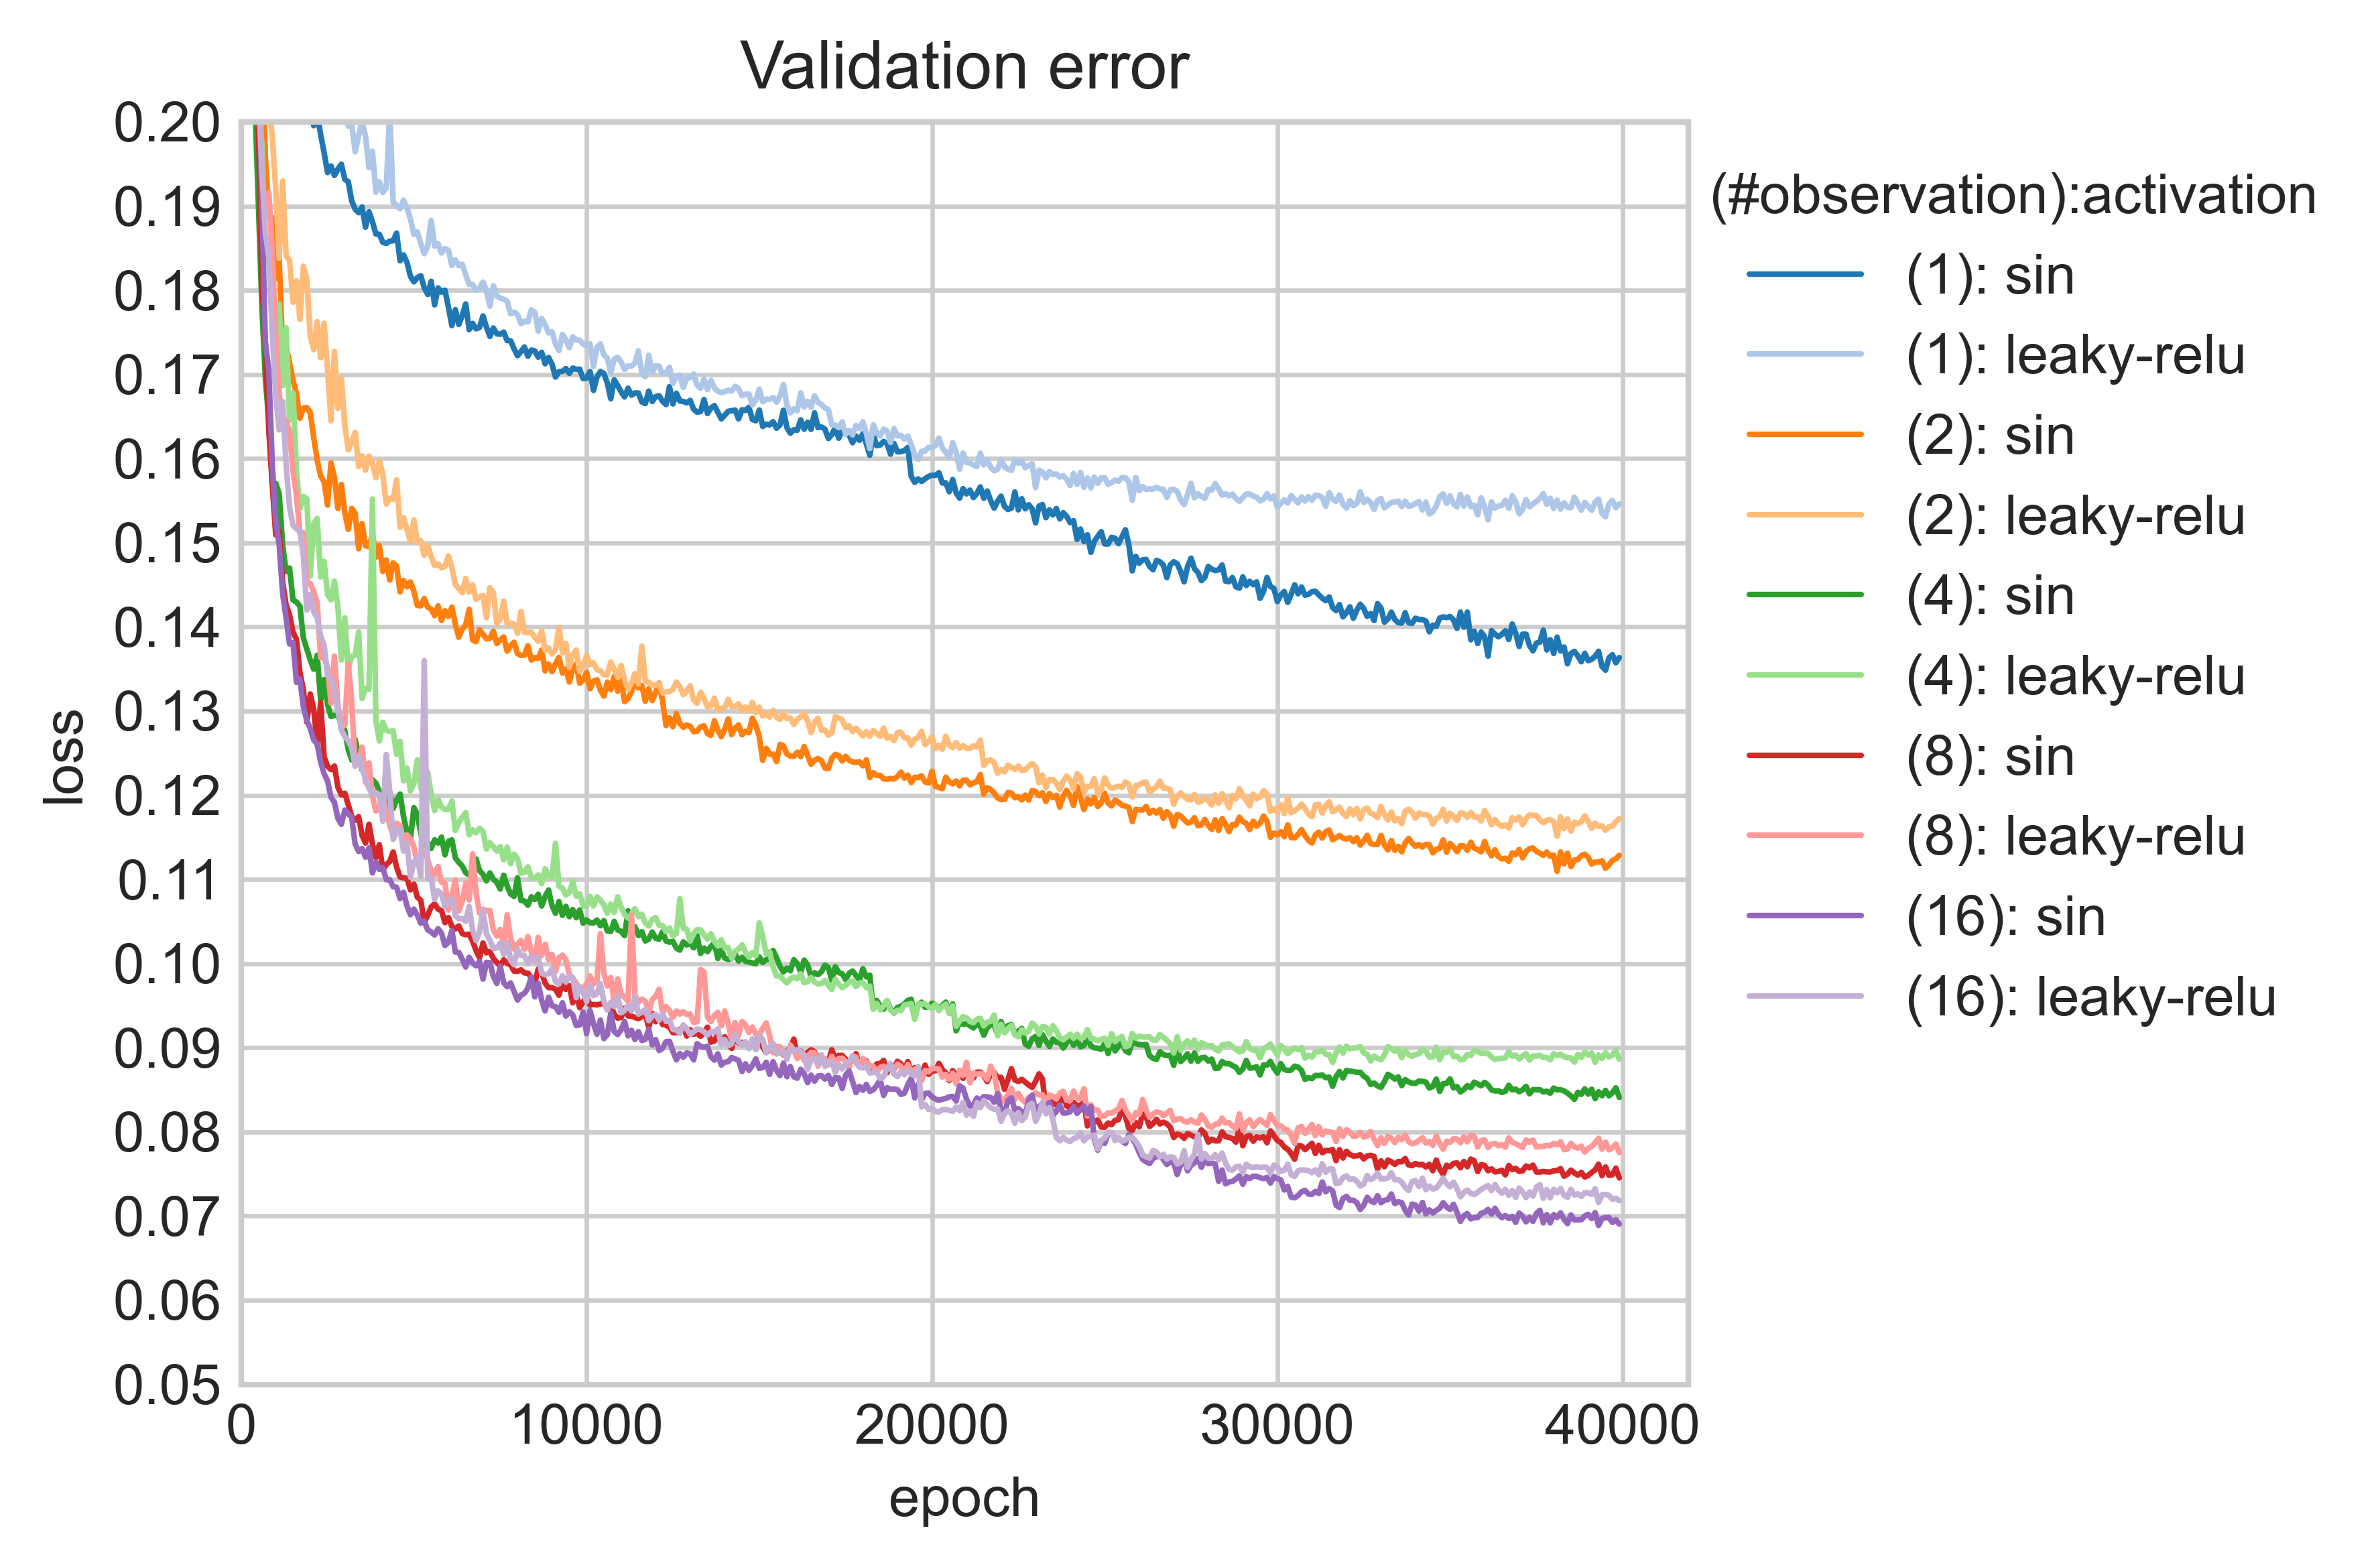

In [40]:
cmap = plt.get_cmap('tab20')
plt.figure(dpi=300,figsize=(6,4))

for k,history_size in enumerate(2**np.arange(5)):
    plt.plot(h_sin[k]["epoch"],h_sin[k]["val_loss"],label=f"({history_size}): sin",linewidth=1,color=cmap.colors[2*k])
    plt.plot(h_leak[k]["epoch"],h_leak[k]["val_loss"],label=f"({history_size}): leaky-relu",linewidth=1,color=cmap.colors[2*k+1])

plt.ylim([0.06,0.2])
plt.yticks(np.linspace(0.05,0.2,16))
plt.xlim(0)

plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(title="(#observation):activation",bbox_to_anchor=(0.98, 1), loc='upper left')
plt.title("Validation error")
plt.tight_layout()
# plt.savefig(f"baseline_h[{history_size}].jpg")
# plt.savefig("compare.jpg",dpi=600)

In [32]:
history_size = 16
# model_path = f"../../data/model_res_baseline_h[{history_size}].torch_model"
# model_path = f"../../data/model_res_sin_baseline_h[{history_size}].torch_model"
# model_path = f"../../data/model_res_rnn_baseline_h[{history_size}].torch_model"

checkpoint = torch.load(model_path)
model = ModelBase(state_size, action_size,history_size).to(device)  # .double()
model.load_state_dict(checkpoint['model_state_dict'])
loss_history_ = checkpoint['loss_history']

In [115]:
from scipy.signal import savgol_filter
# yhat = savgol_filter(y, 51, 3) # window size 51, polynomial order 3

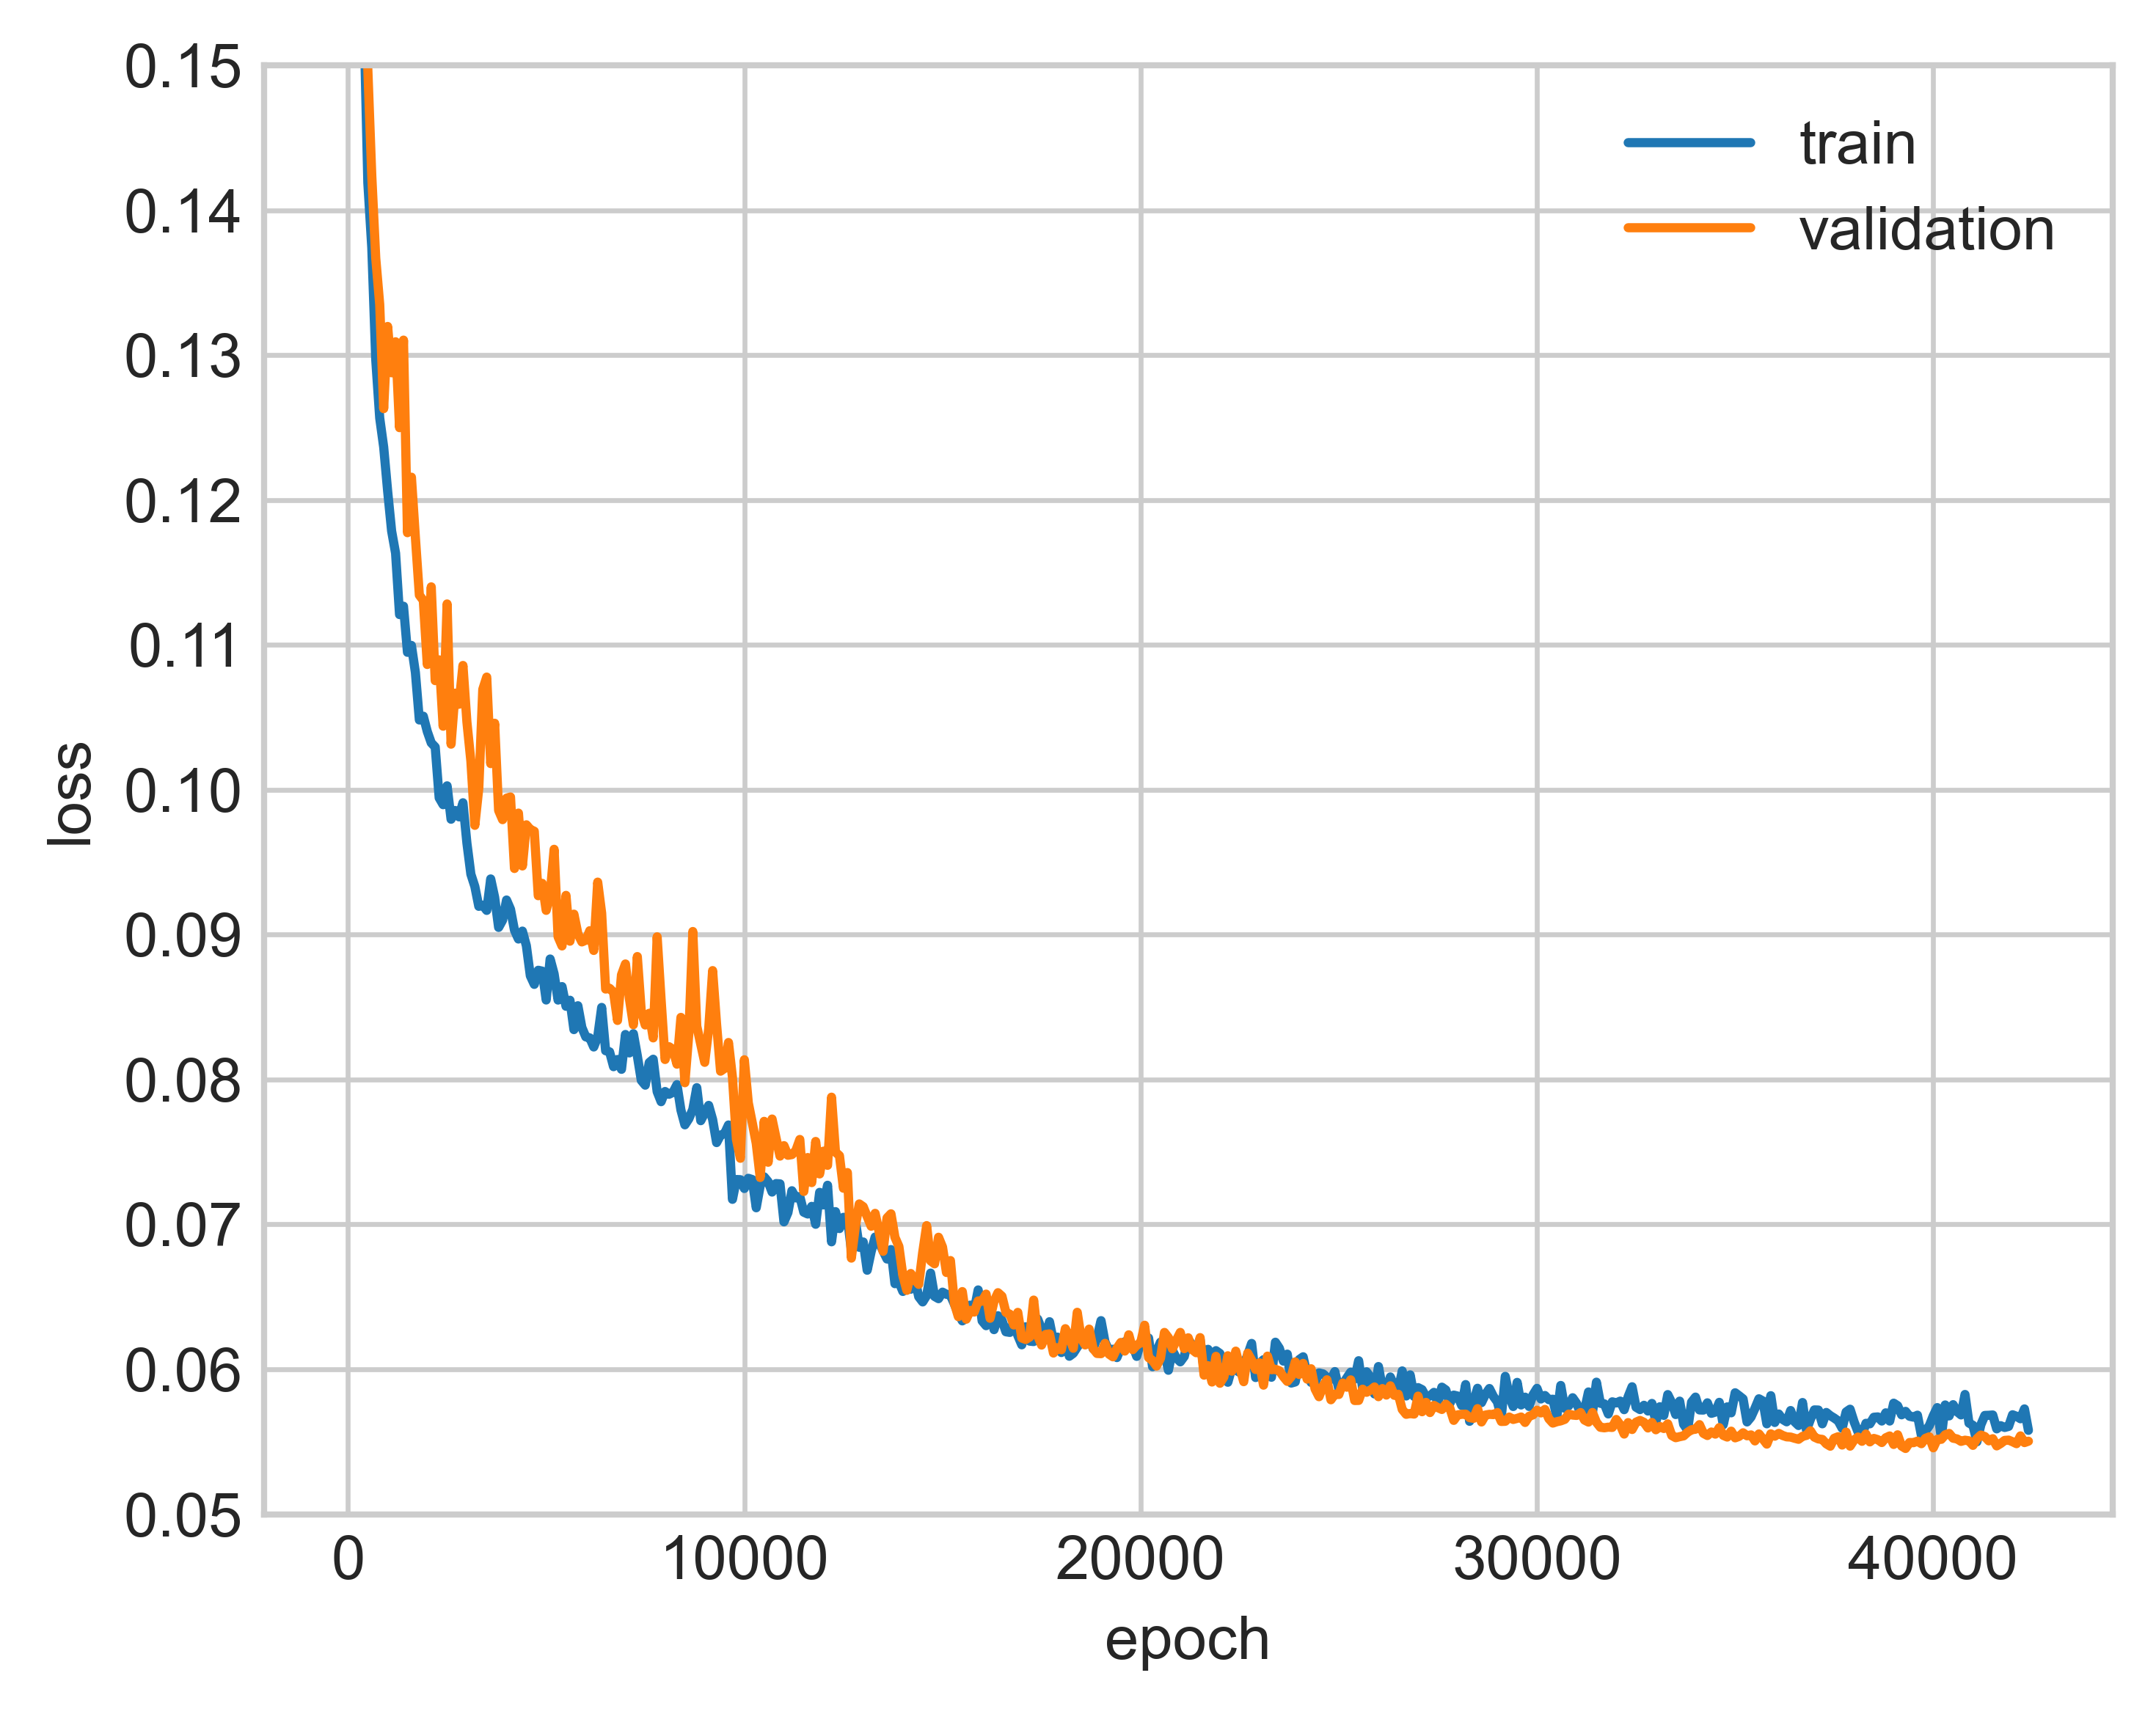

In [26]:
plt.figure(dpi=300,figsize=(5,4))

plt.plot(loss_history["epoch"],loss_history["train_loss"],label="train")
plt.plot(loss_history["epoch"],loss_history["val_loss"],label="validation")

# plt.ylim([np.min(loss_history["train_loss"]),loss_history["train_loss"][10]])
# plt.ylim([0.08,0.25])
plt.ylim([0.05,0.15])
plt.yticks(np.linspace(0.05,0.15,11))

plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.tight_layout()
plt.savefig(f"baseline_h[{history_size}].jpg")

In [33]:
model.eval()
torch.set_grad_enabled(False)

batch_data = base_val_dataset[batch%len(base_val_dataset)]

s0 = batch_data["s0"].to(device, non_blocking=True)
s1 = batch_data["s1"].to(device, non_blocking=True)
a0 = batch_data["a0"].to(device, non_blocking=True)
#         print(s0.shape,a0.shape,s1.shape)
s1_pred = model(s0, a0)
val_loss = criterion(s1_pred, s1[:,-1]).item()
same_pred_loss = criterion(s0[:,-1], s1[:,-1]).item()
print(f"val loss:\nsame prediction = {same_pred_loss:.3f}\n net prediction = {val_loss:.3f}")
a0_pred = model.inverse_dynamics(s0,s1)

print(criterion(a0_pred, a0[:,-1]).item())
print(criterion(a0[:,-2], a0[:,-1]).item())

val loss:
same prediction = 0.183
 net prediction = 0.052
0.017492763698101044
0.011018951423466206


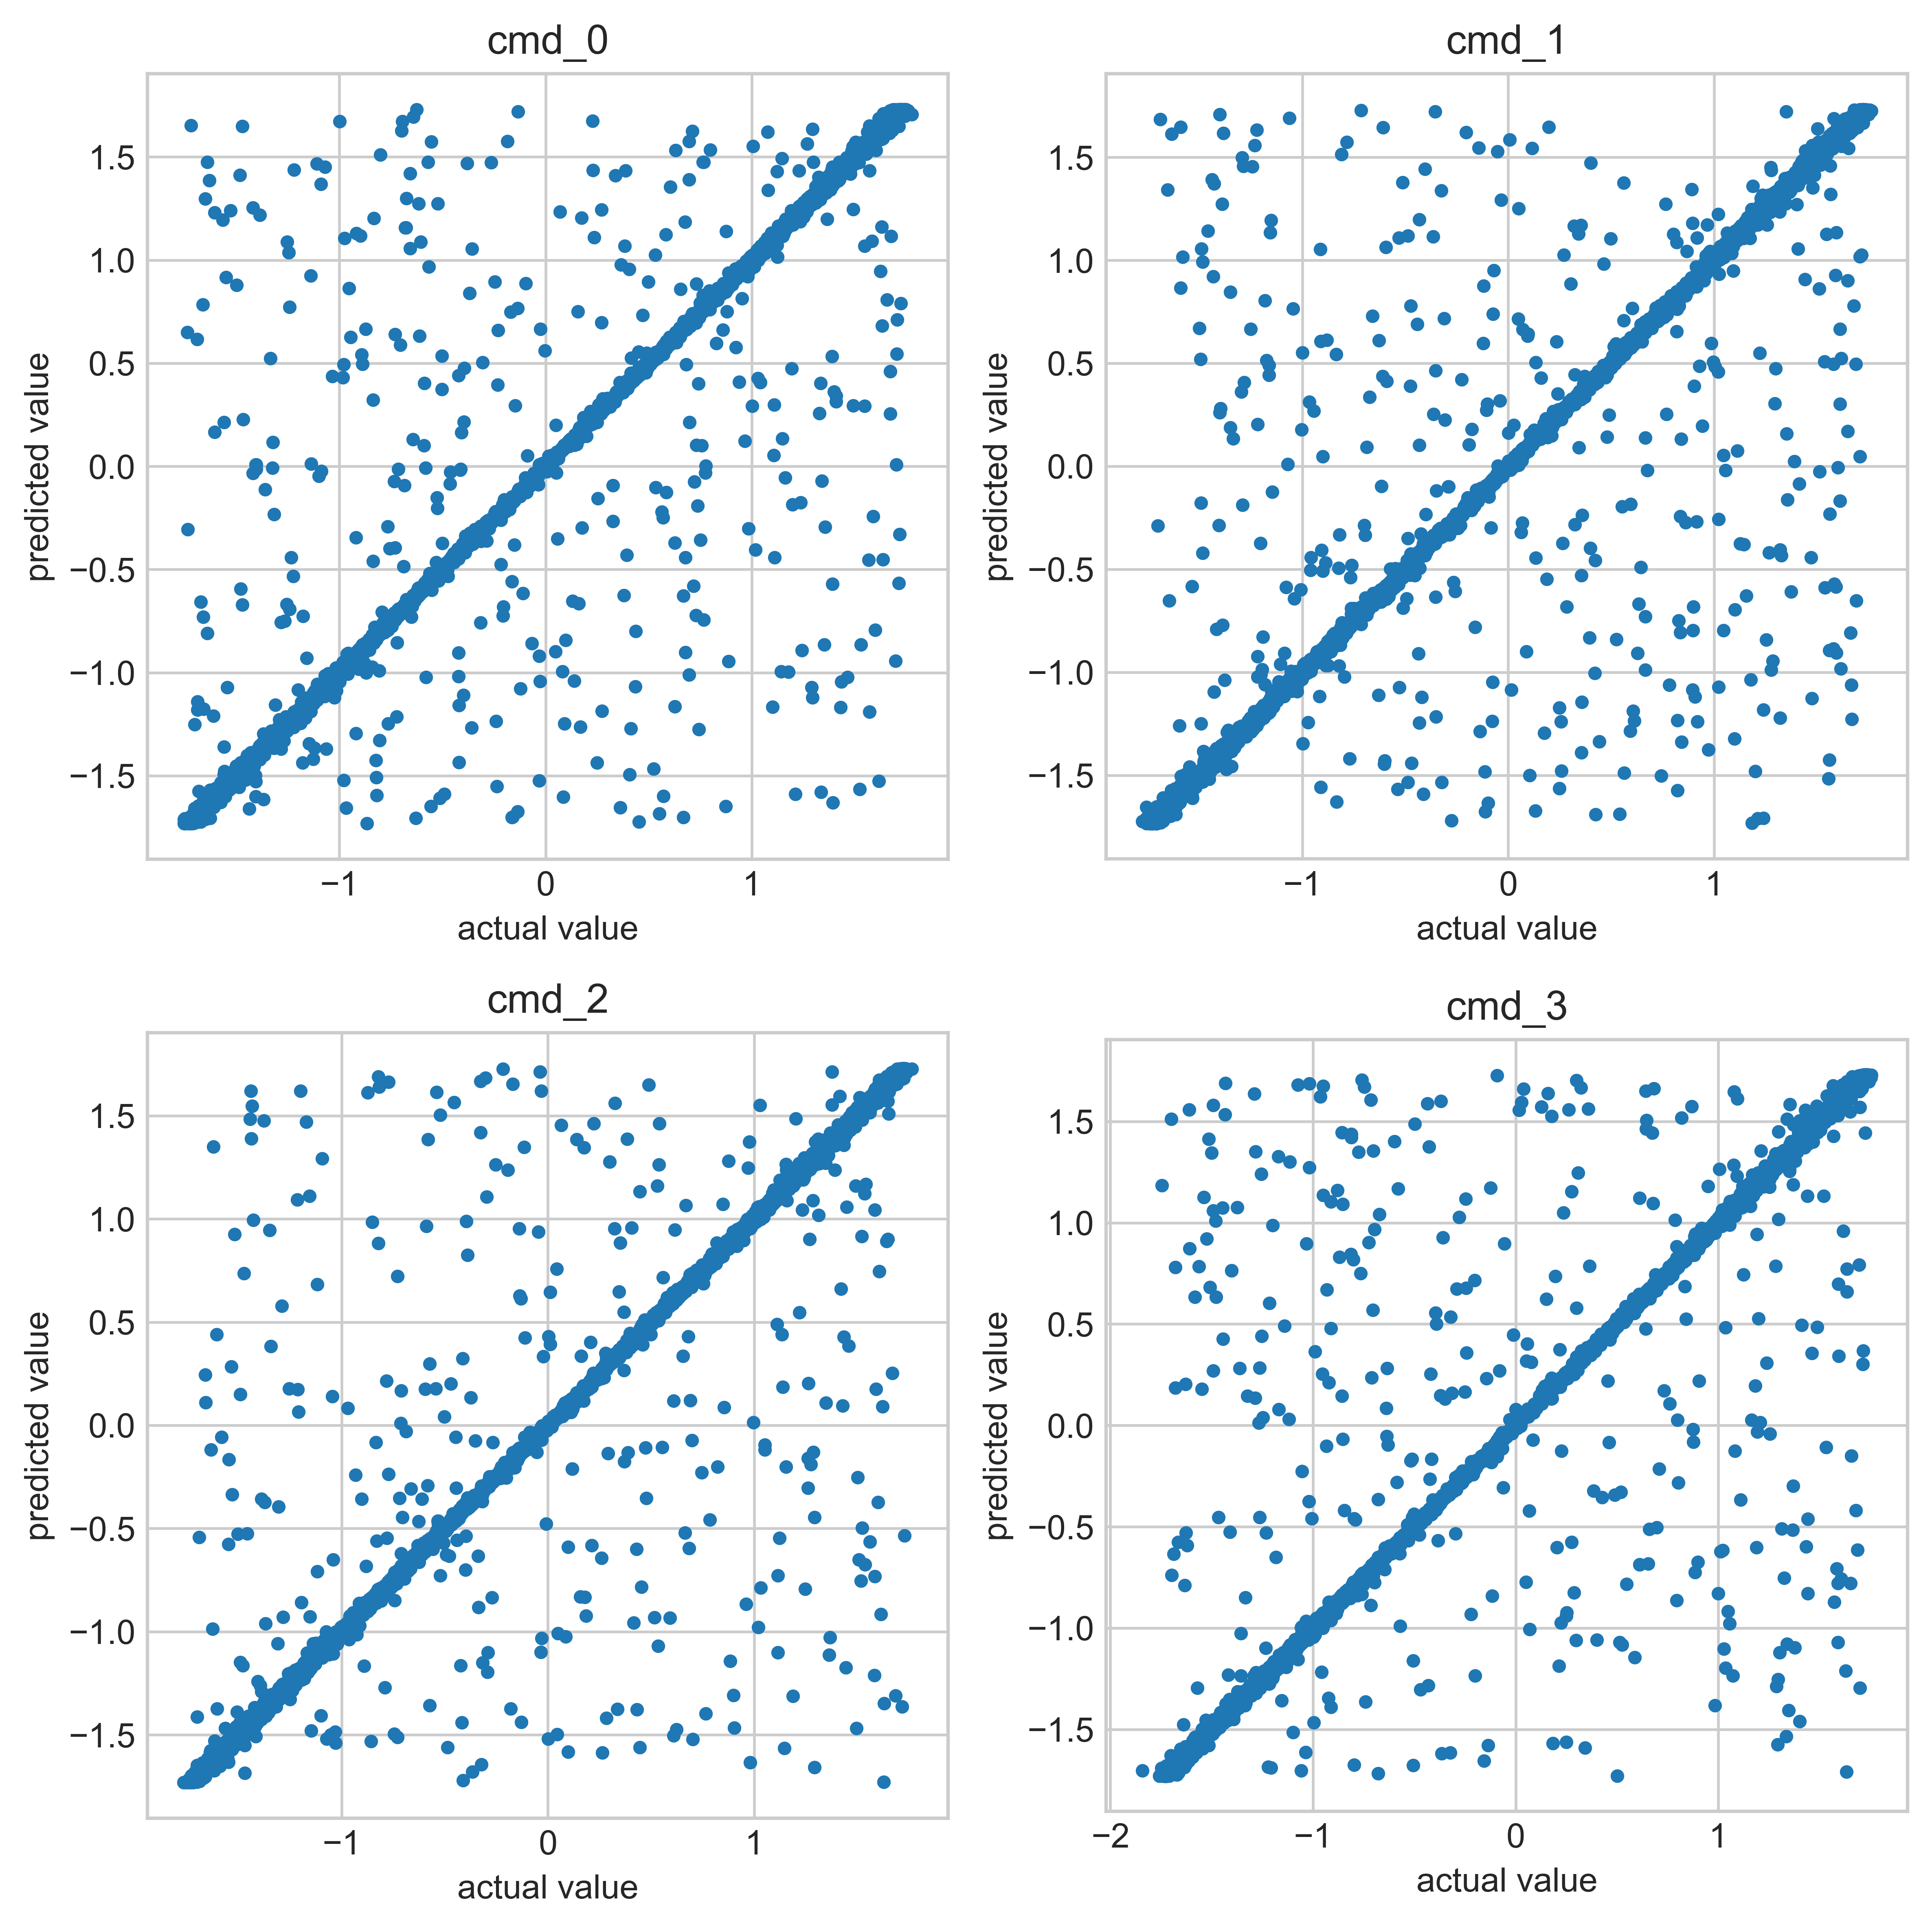

In [34]:
fig, ax = plt.subplots(2,2,figsize = (4*2,4*2),dpi=300)
for k in range(4):
    i = (k%4)//2
    j = (k%4)%2
    ax[i,j].plot(a0_pred.cpu().numpy()[:,k],a0[:,-1,k].cpu().numpy(),'.')
    
    ax[i,j].set_title(columns_flat[columns_index[ID["cmd"]]+k])
    ax[i,j].set_xlabel("actual value")
    ax[i,j].set_ylabel("predicted value")
    ax[i,j].set_aspect('equal', 'box')
plt.tight_layout()
# plt.savefig(f"h[{history_size}]-cmd.jpg")

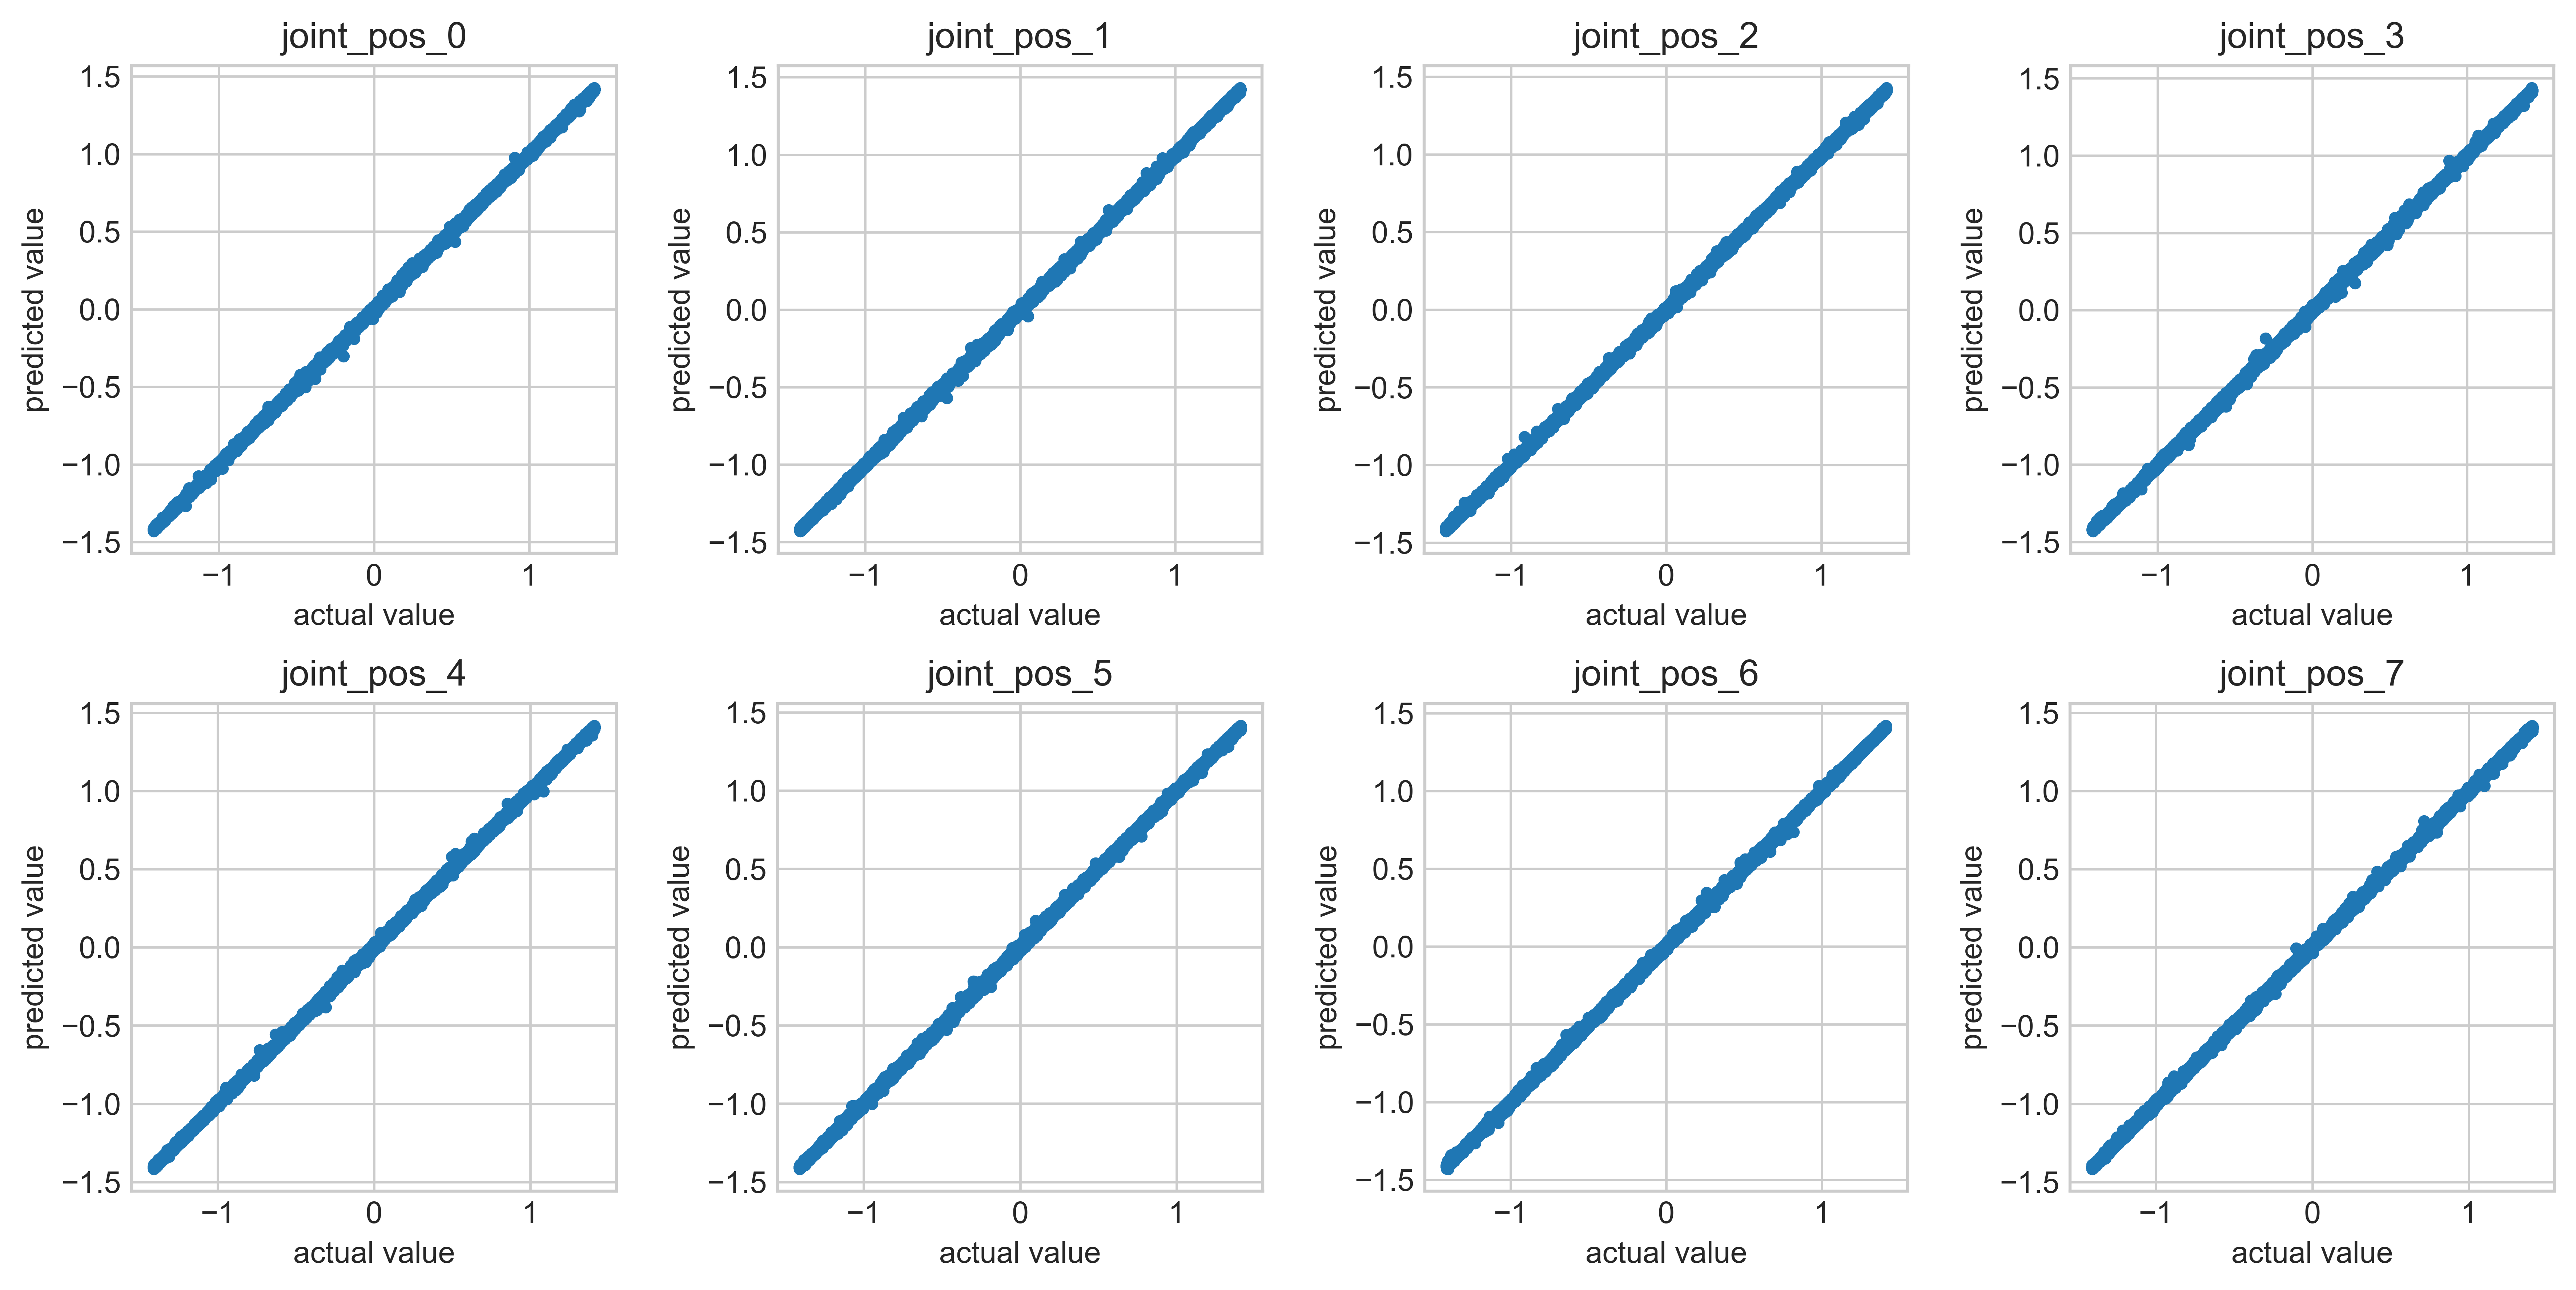

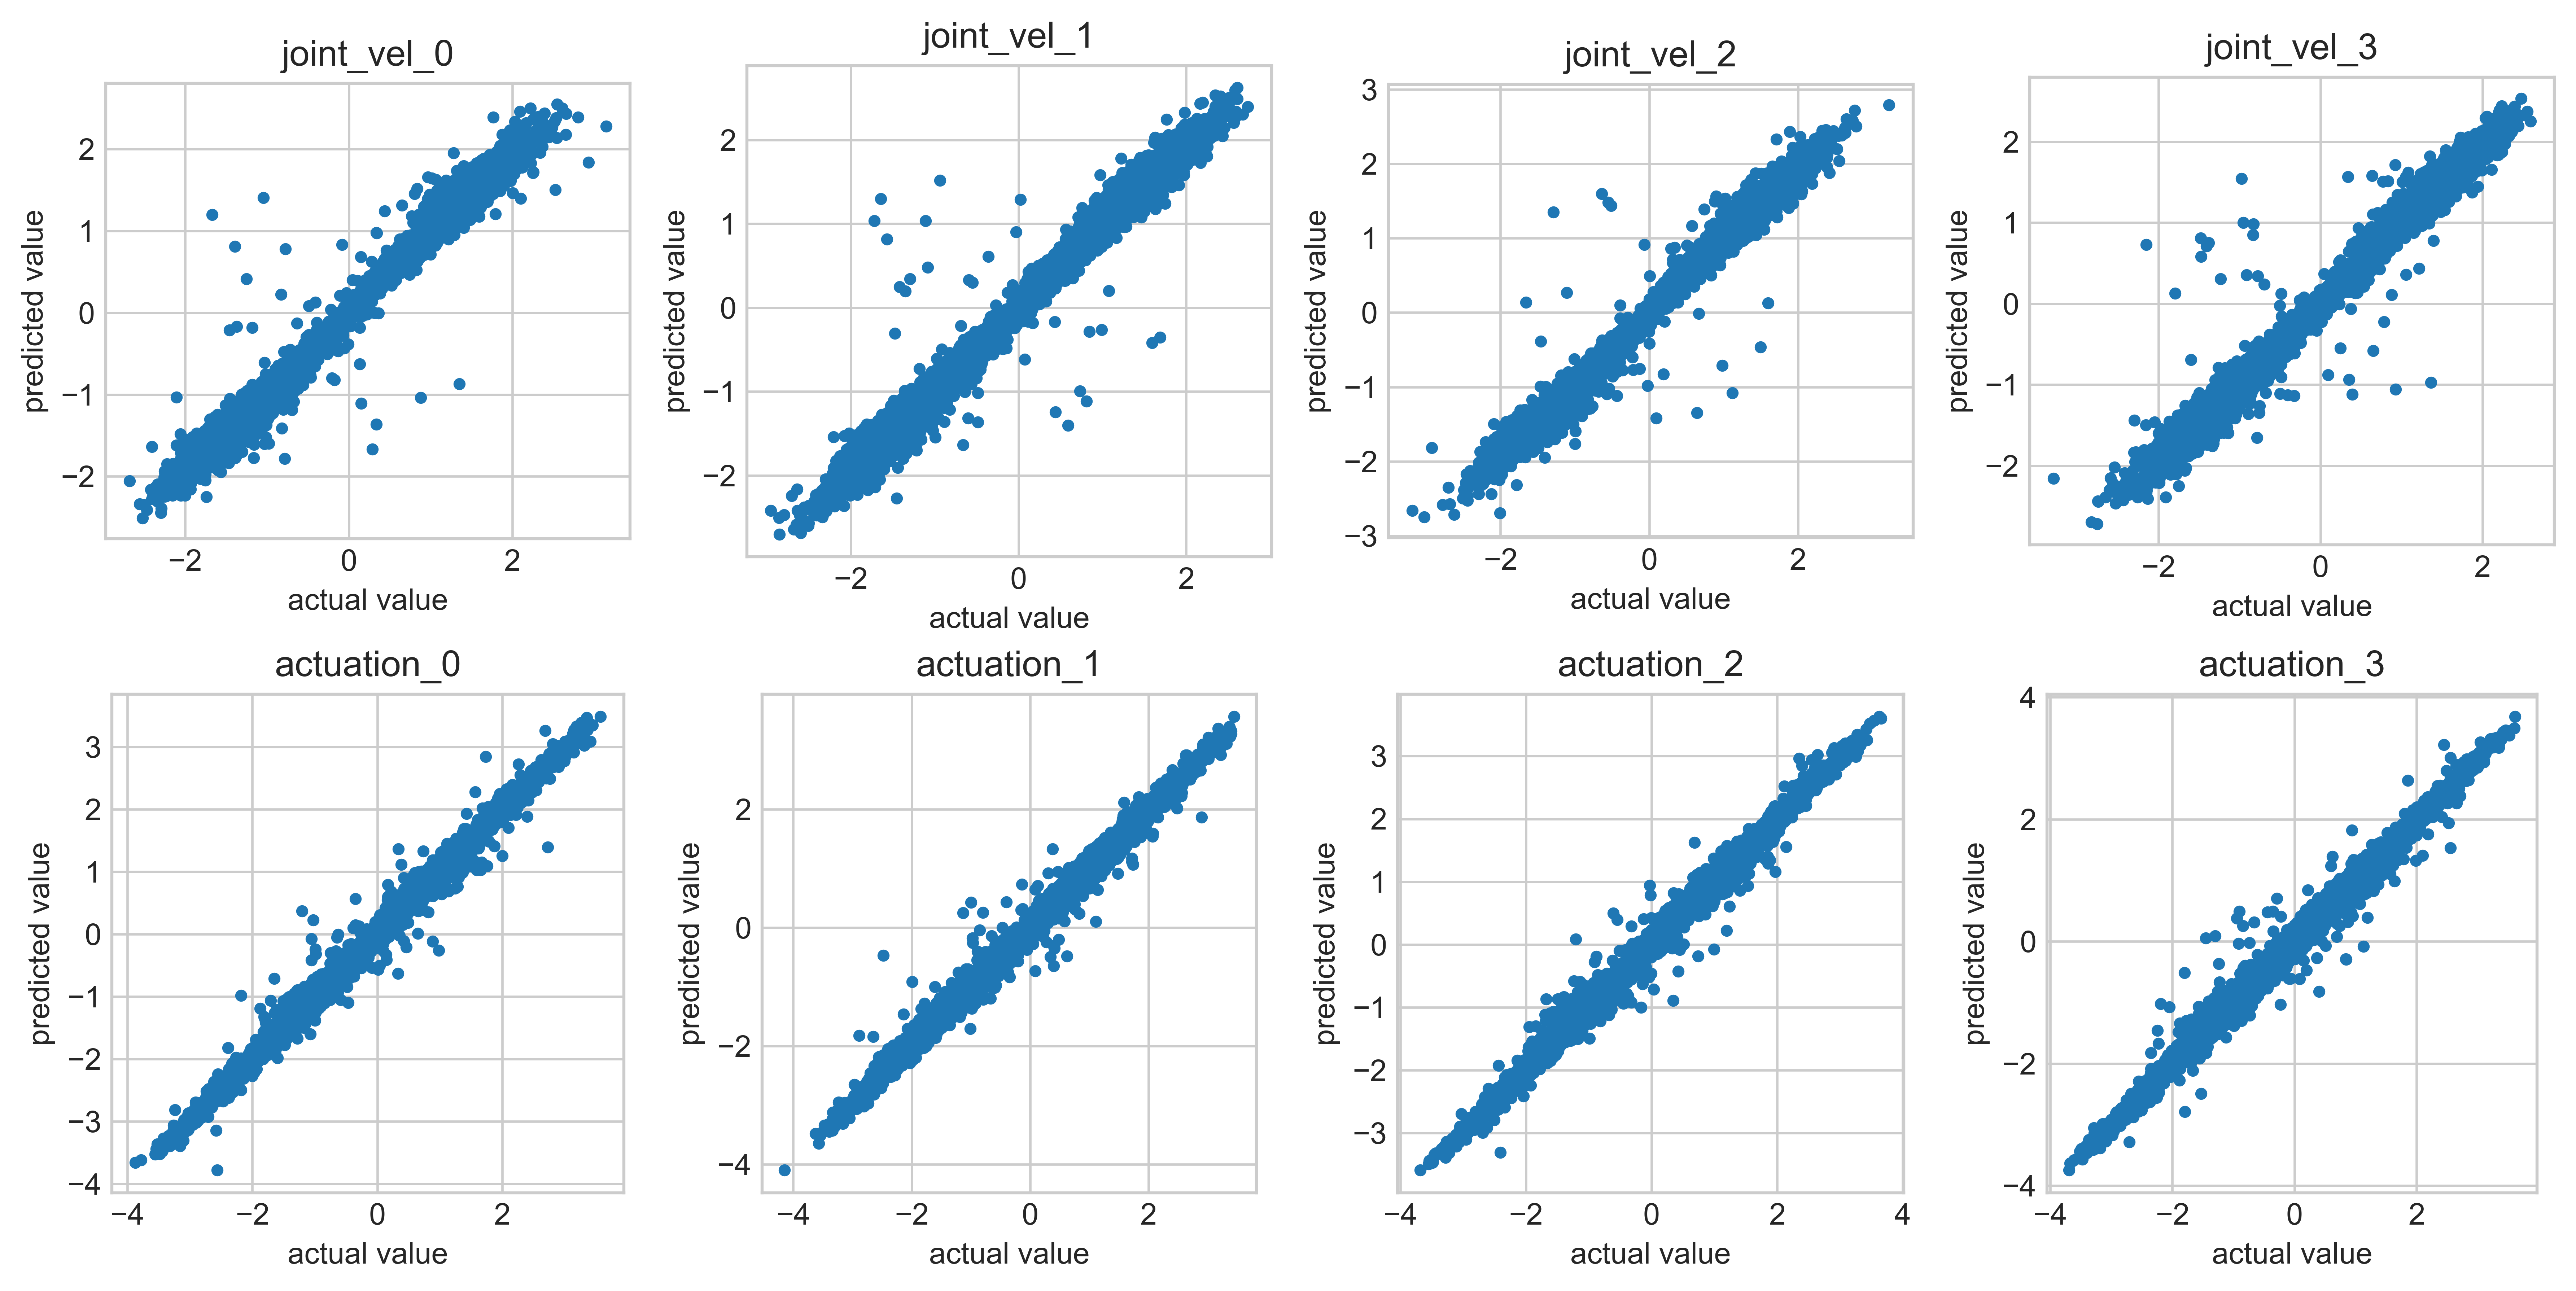

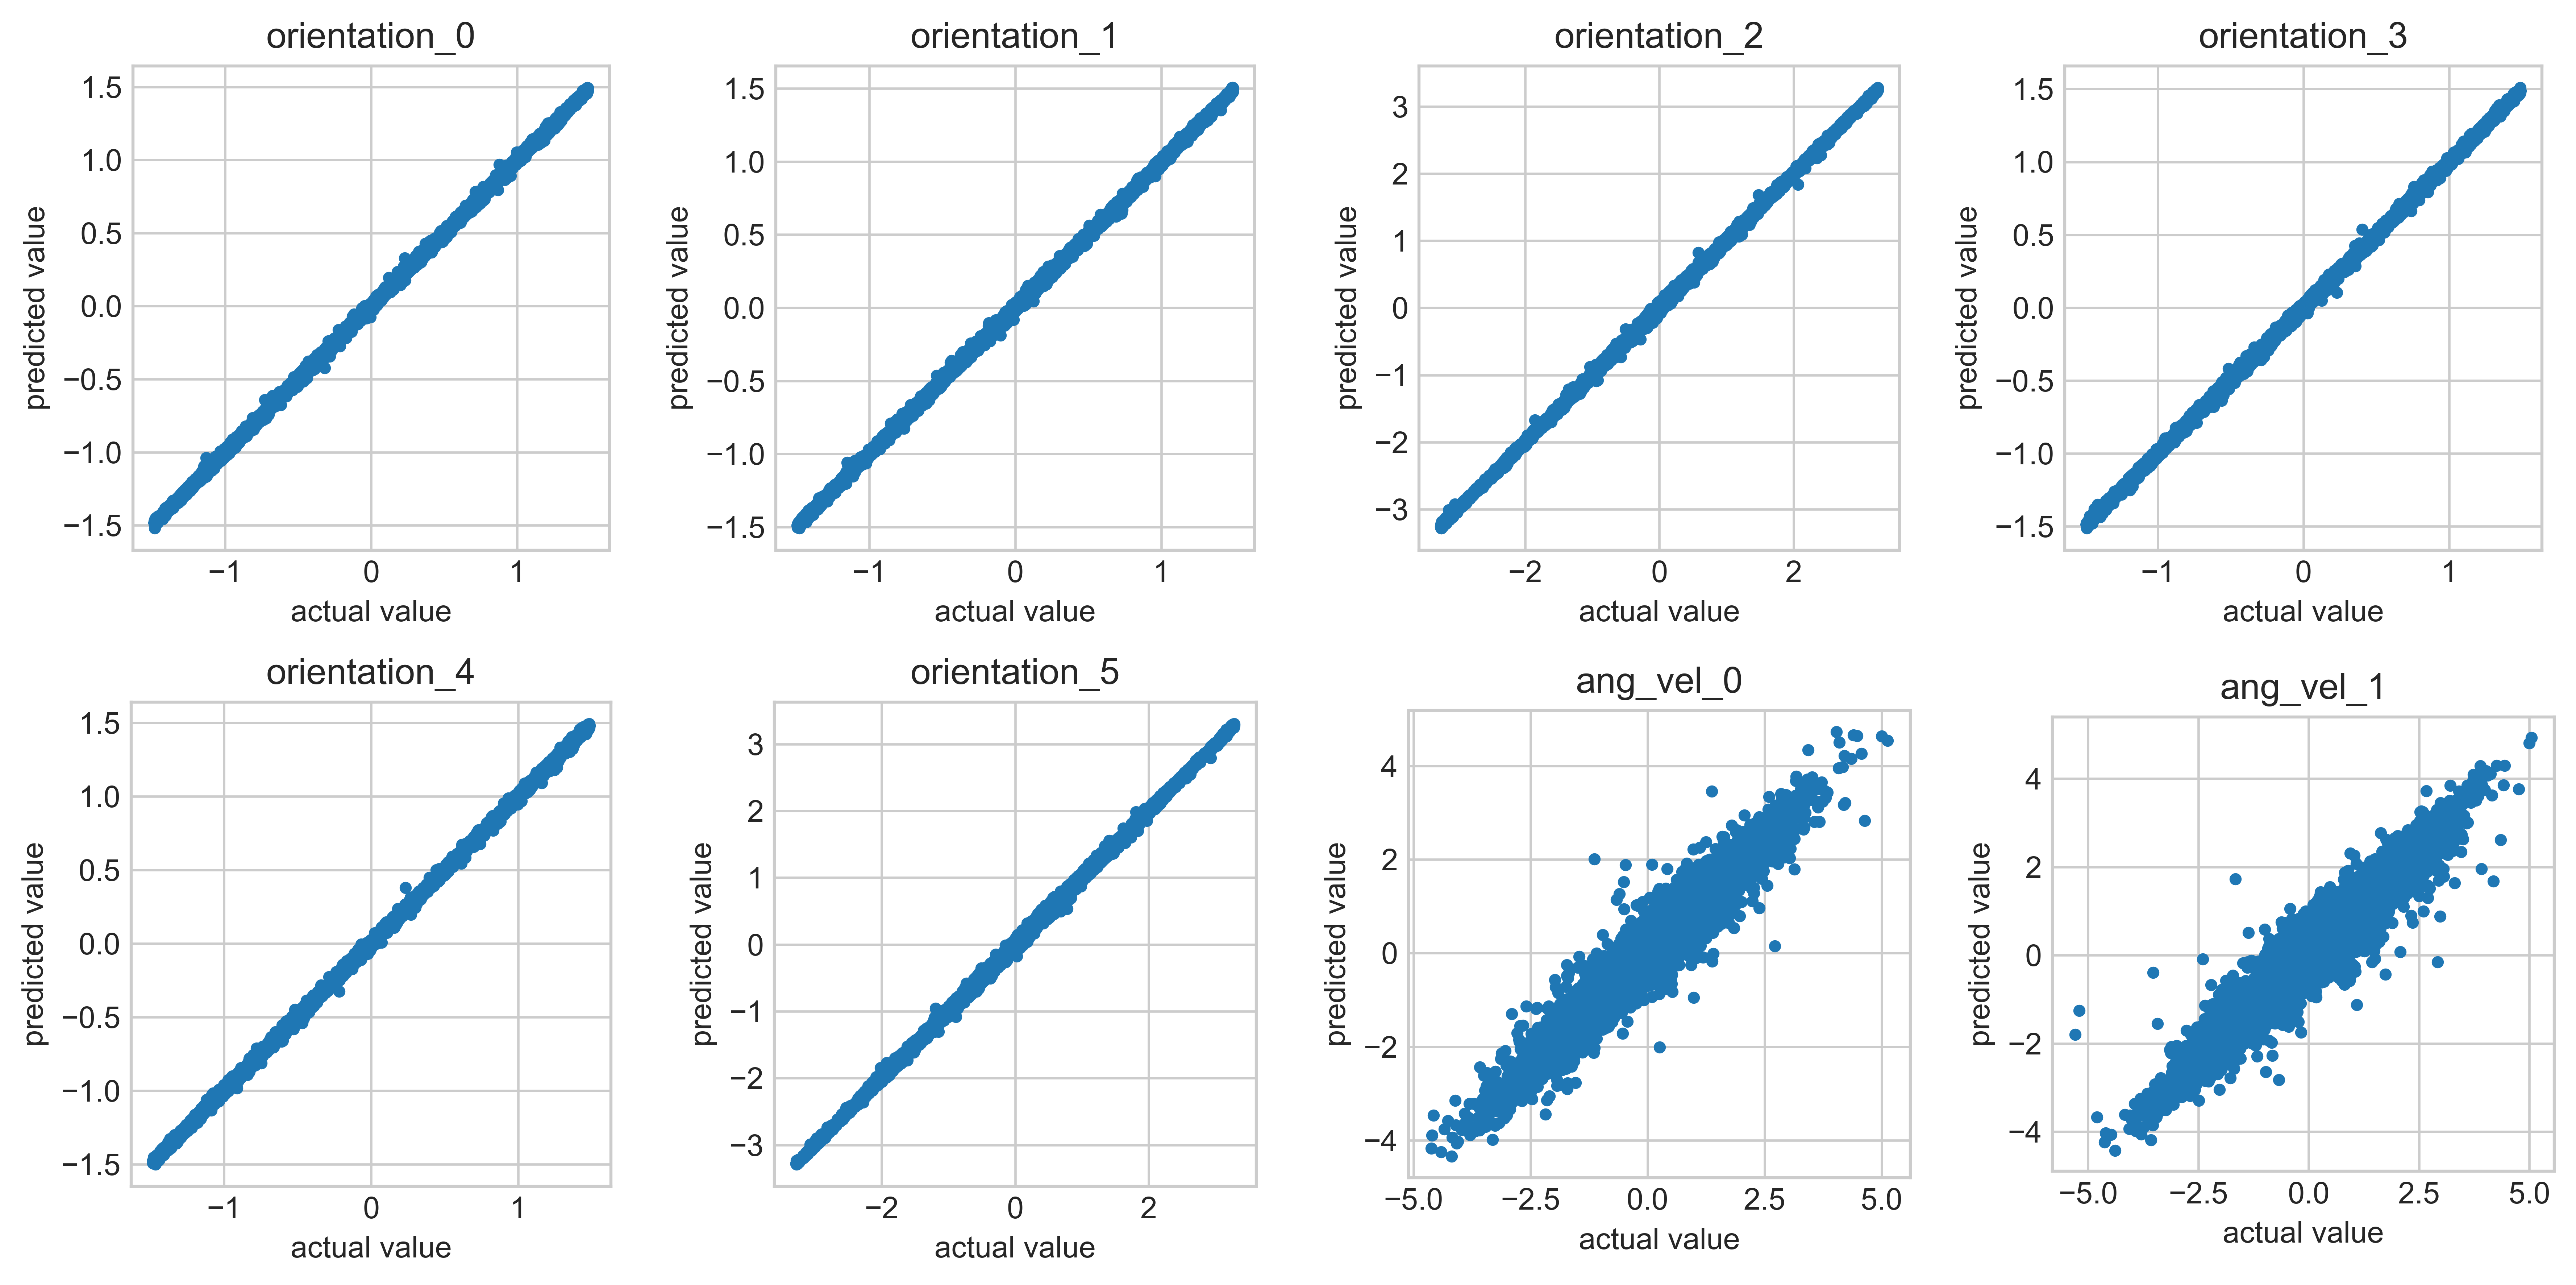

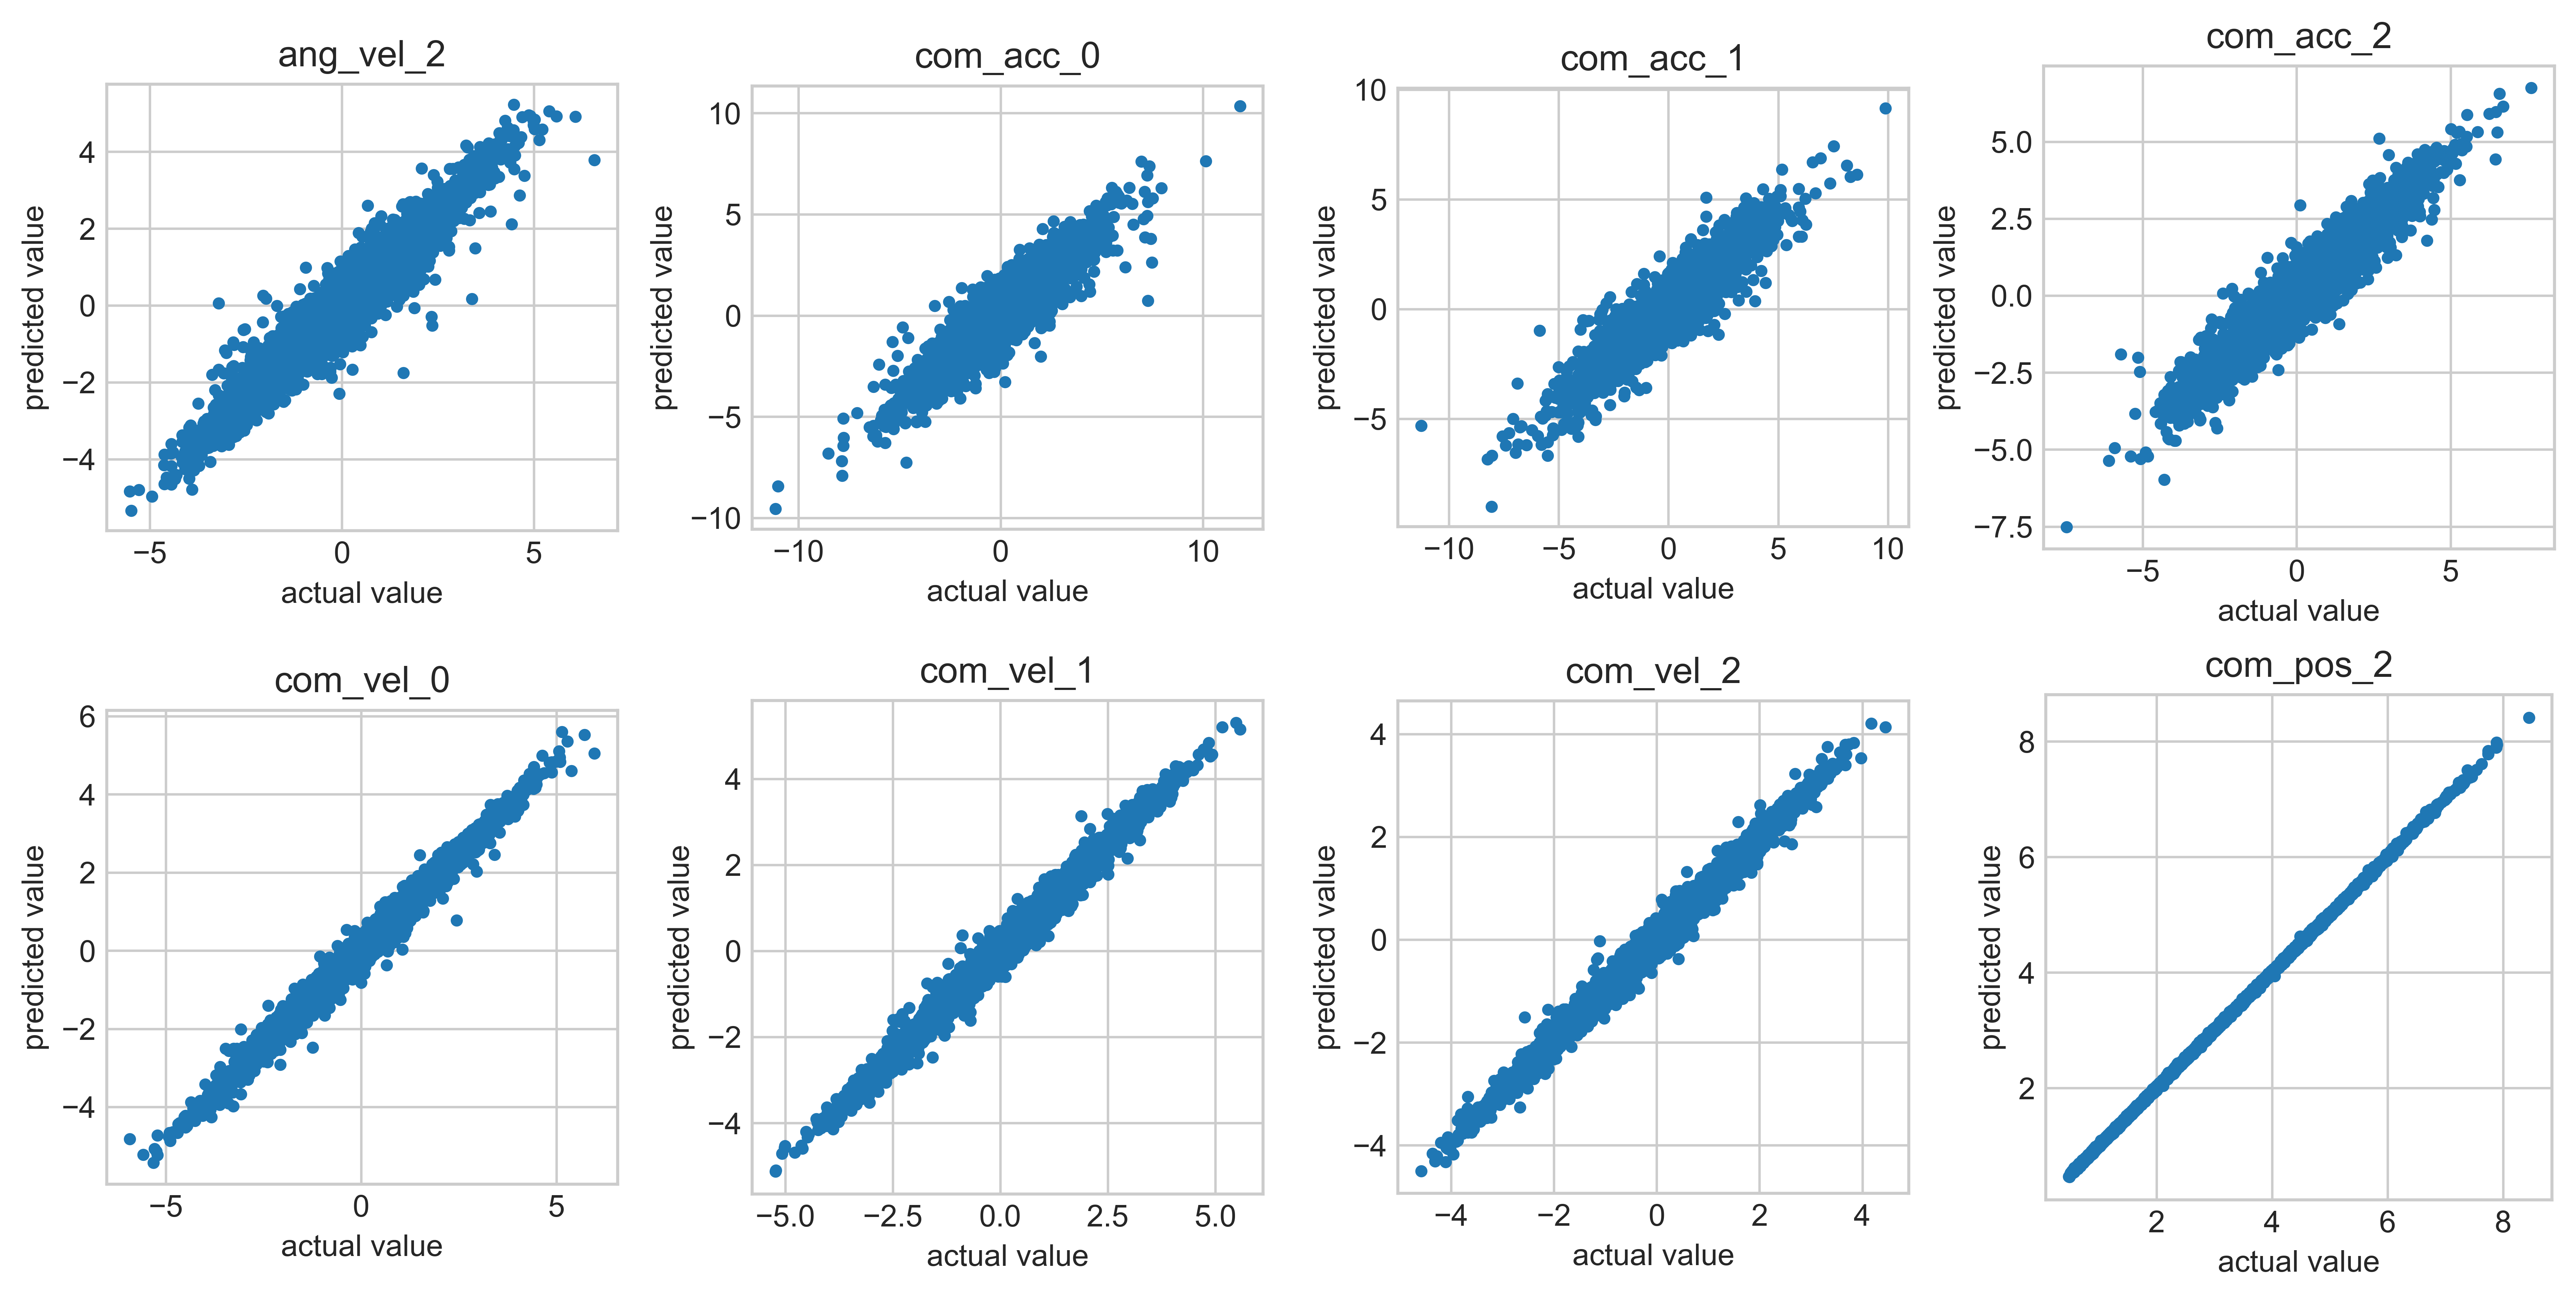

In [30]:
n_row = int(np.ceil(state_size//2))
# fig, ax = plt.subplots(n_row,2,figsize = (4*2,4*n_row),dpi=300)
for k,c_pred in enumerate(s1_pred.T.cpu().numpy()):
    c_real = s1[:,-1].T[k].cpu().numpy()
#     i = k//2
#     j = k%2
    
    i = (k%8)//4
    j = (k%8)%4
    if k%8==0:
        fig, ax = plt.subplots(2,4,figsize = (3*4,3*2),dpi=300)
#     print(i,j)
    ax[i,j].plot(c_real,c_pred,'.')

#     ax[i,j].plot(np.cos(c_real),np.cos(c_pred),'.')
    ax[i,j].set_title(columns_flat[state_columns[k]])
    ax[i,j].set_xlabel("actual value")
    ax[i,j].set_ylabel("predicted value")
    ax[i,j].set_aspect('equal', 'box')
#     plt.show()
#     if k>2:
#         break
#     plt.tight_layout()
    if k%8==7:
        plt.tight_layout()
        plt.savefig(f"h[{history_size}]-{k//8}.jpg")
        plt.show()

In [324]:
model.eval()
torch.set_grad_enabled(False)

criterion = nn.L1Loss() # raw loss

batch_data = getBatchData(state, action, state_next,indices_val, batch_size=int(len(indices_val)/2), batch_id=0)
s0, s1, a0 = batch_data["s0"].to(device), batch_data["s1"].to(device), batch_data["a0"].to(device)
s1_pred = model(s0, a0)
loss = criterion(s1_pred, s1)
val_loss = loss.item()
val_loss

2728.8046875

In [325]:
model.eval()
torch.set_grad_enabled(False)

criterion = nn.L1Loss() # raw loss

n_steps = 500
n_trial = 10
loss_arr = np.empty((n_trial,n_steps))
for i in range(n_trial):
    
    id_start = np.random.randint(len(indices_train),len(indices_train)+len(indices_val))
    batch_data = getBatchData(state, action, state_next,indices, batch_size=1, batch_id=id_start)
    s0, s1, a0 = batch_data["s0"].to(device), batch_data["s1"].to(device), batch_data["a0"].to(device)
    s1_pred = model(s0, a0)

    for k in range(n_steps):
        batch_data = getBatchData(state, action, state_next,indices, batch_size=1, batch_id=id_start+k)
        s0, s1, a0 = batch_data["s0"].to(device), batch_data["s1"].to(device), batch_data["a0"].to(device)
        s1_pred = model(s1_pred, a0)
        loss = criterion(s1_pred, s1)
        loss_arr[i,k] = loss.item()

In [326]:
df_loss = pd.DataFrame(np.array([np.tile(np.arange(n_steps),n_trial),loss_arr.ravel()]).T,columns=["step","loss"])

<AxesSubplot:xlabel='step', ylabel='loss'>

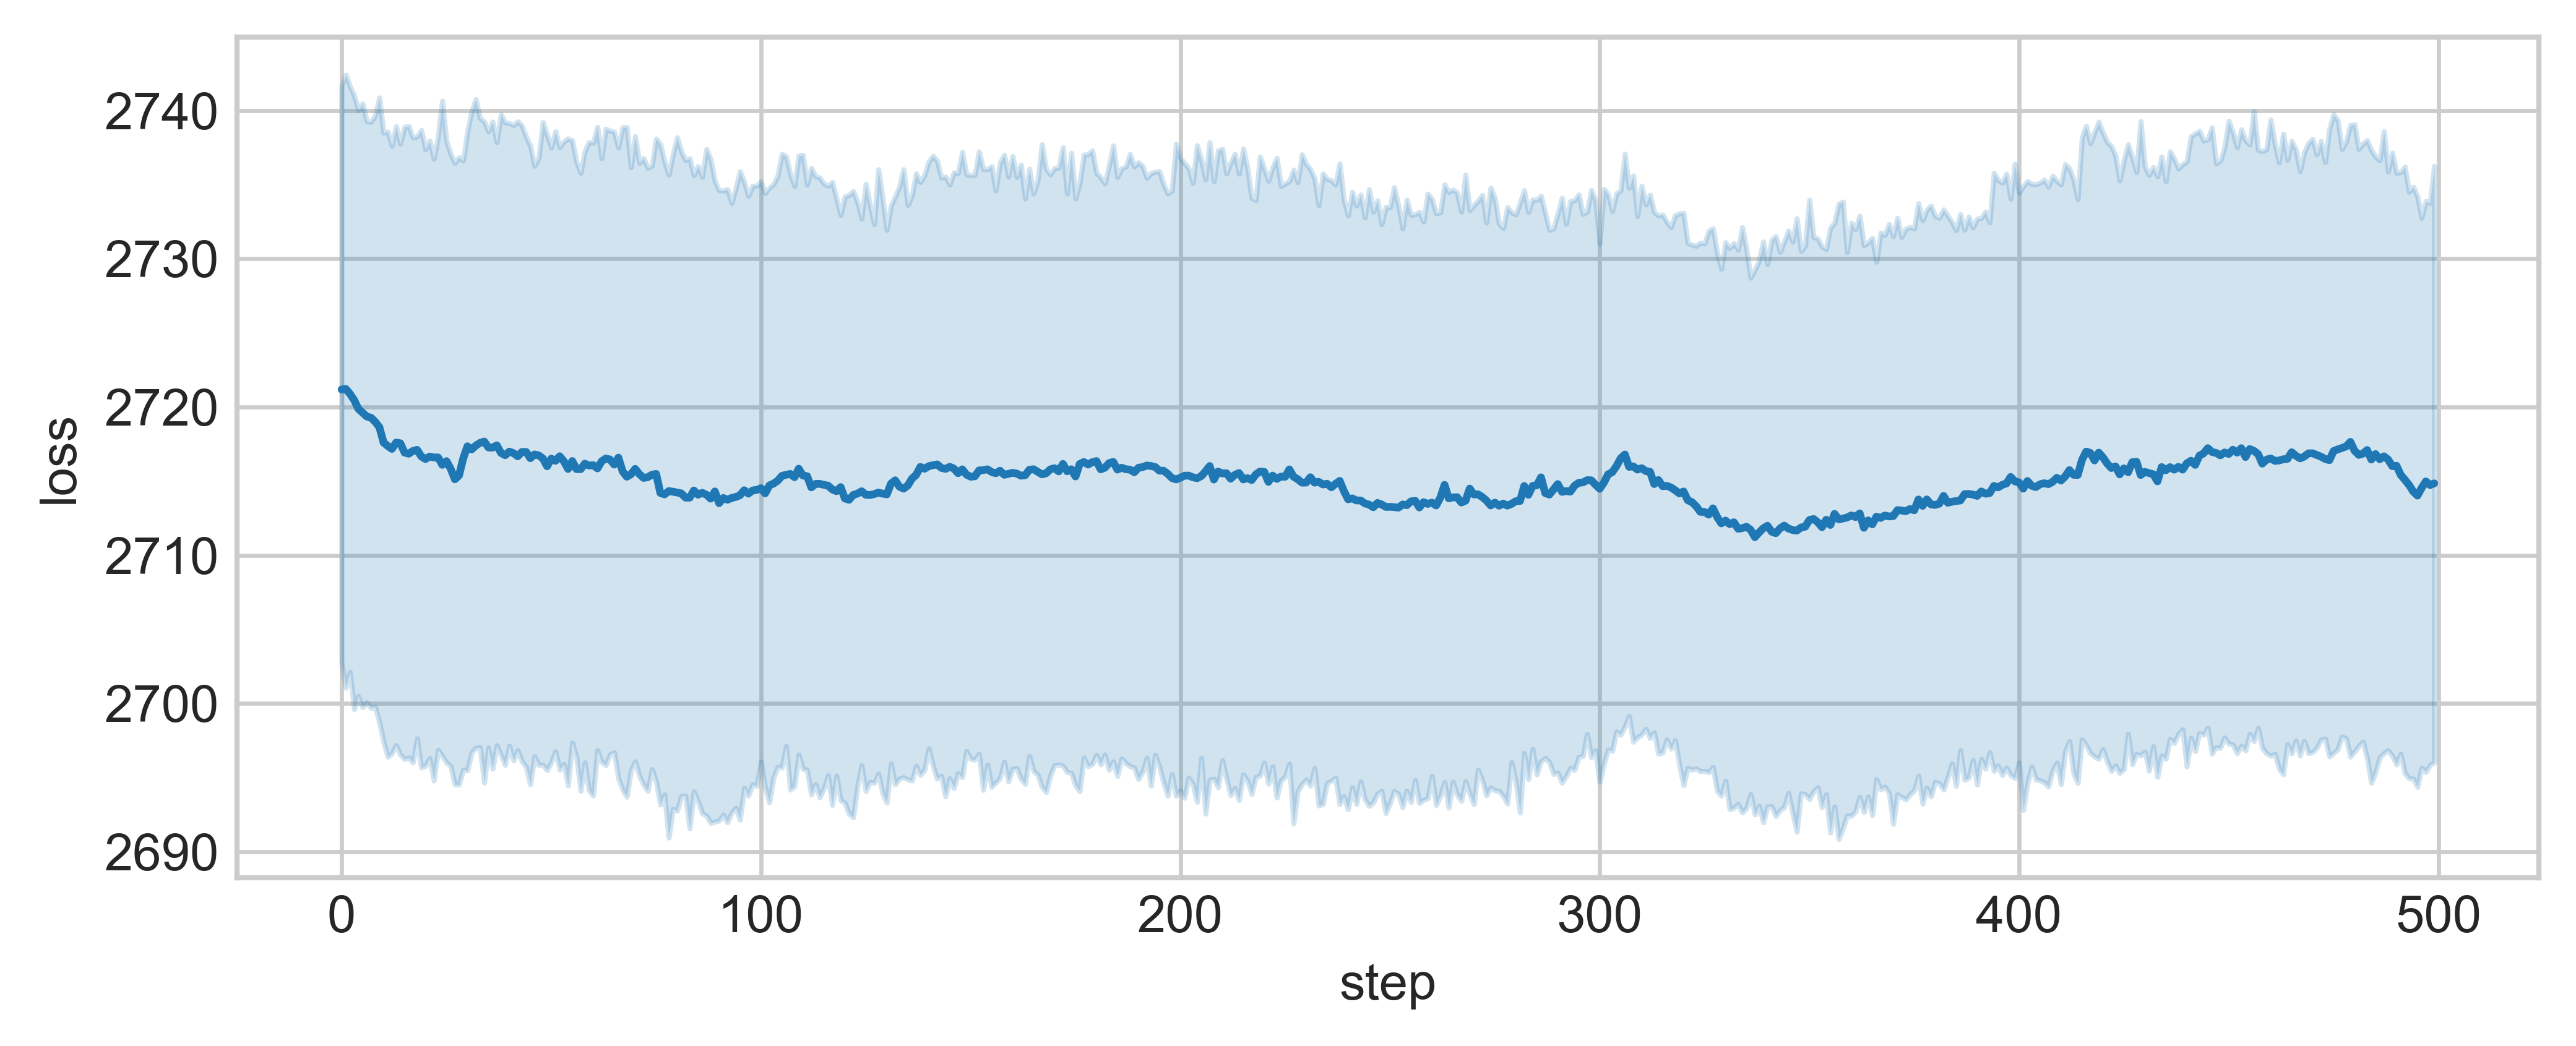

In [328]:
plt.figure(dpi=300,figsize=(8,3))
# plt.plot(loss_arr.T)
sns.lineplot(x="step",y="loss",data=df_loss)
# plt.legend(range(n_trial),title="trial")
# plt.xlabel("steps")
# plt.ylabel("loss")
# plt.savefig("n_steps_prediction.png",dpi=600)

In [135]:
model.eval()

MyModel(
  (encoder_s): Sequential(
    (0): Linear(in_features=28, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (encoder_a): Sequential(
    (0): Linear(in_features=4, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope

In [ ]:
s0, s1, a0 = state[0].to(device), batch_data["s1"].to(device), batch_data["a0"].to(device)

In [209]:
np.state[0]

array([  2.4604056 ,  -1.89323028,   0.40613029,  -1.93339715,
         0.8833979 ,  -8.26327873,  -1.93880644,   7.74912322,
        -0.08398987,  -0.15075459,   0.01678319,   0.1090264 ,
         0.77799359,   0.31201871,   0.54531669,  -0.33914811,
         0.93920827,  -0.05353861,  -3.71295352,   1.28168113,
        -0.97893795,  -2.1528586 , -10.09296843,   6.88349414,
         0.20228271,   0.26967977,  -0.52503022])

In [180]:
model

MyModel(
  (encoder_s): Sequential(
    (0): Linear(in_features=27, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.01, inplace=True)
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): LeakyReLU(negative_slope=0.01, inplace=True)
    (10): Linear(in_features=256, out_features=256, bias=True)
    (11): LeakyReLU(negative_slope=0.01, inplace=True)
    (12): Linear(in_features=256, out_features=256, bias=True)
    (13): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (encoder_a): Sequential(
    (0): Linear(in_features=4, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    

In [855]:
# def getBatchData(state, action, state_next, indices, batch_size, batch_id):
#     len_data = len(indices)
#     batch_start = (batch_id*batch_size) % len_data
#     batch_end = (batch_id*batch_size+batch_size) % len_data
#     if batch_start==batch_end:
#         batch_start = 0
#         batch_end = len_data
#     elif batch_end < batch_start:
#         batch_indices = np.concatenate(
#             (indices[batch_start:], indices[:batch_end]))
#     else:
#         batch_indices = indices[batch_start:batch_end]

#     batch_data = {
#         "s0": torch.from_numpy(state[batch_indices]),
#         "a0": torch.from_numpy(action[batch_indices]),
#         "s1": torch.from_numpy(state_next[batch_indices])
#     }
#     return batch_data

In [ ]:
# from multiprocessing import shared_memory
# import multiprocessing as mp

# def createSharedMemArray(arr_shape, arr_dtype = np.float32):
#     """
#     create a shared memory arry given its shape and dtype
#     to delete the arr:
#         del arr
#         shm.close()
#         shm.unlink()
#     """
#     arr_nbytes = int(np.prod(arr_shape)*np.dtype(arr_dtype).itemsize)
#     shm = shared_memory.SharedMemory(create=True, size=arr_nbytes)
#     arr = np.ndarray(arr_shape, dtype=arr_dtype, buffer=shm.buf)
#     return arr,shm


# def modify(to_arr,from_arr,indices):
#     to_arr[:] = from_arr[indices]


# arr_shape = np.asarray(state.shape,dtype=np.int64)
# arr_shape[0] = indices_train.shape[0]
# arr,_ = createSharedMemArray(arr_shape)

# p = mp.Process(target=modify,args=(arr,state,indices_train))
# p.start()
# p.join()